%load_ext autoreload
%autoreload 2


In [1]:
import numpy as np

from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.utils import TransformContainer
from eryn.moves import GaussianMove
from eryn.backends import HDFBackend

# make the plots look a bit nicer with some defaults
import matplotlib as mpl
import matplotlib.pyplot as plt
rcparams = {}
rcparams["axes.linewidth"] = 0.5
rcparams["font.family"] = "serif"
rcparams["font.size"] = 22
rcparams["legend.fontsize"] = 16
rcparams["mathtext.fontset"] = "stix"
rcparams["text.usetex"] = True 
mpl.rcParams.update(rcparams) # update plot parameters

# set random seed
np.random.seed(42)

import corner
from chainconsumer import ChainConsumer
from scipy import interpolate

# Eryn Basic Tutorial

Eryn is an advanced MCMC sampler. It has the capability to run with parallel tempering, multiple model types, and unknown counts within each model type using Reversible-Jump MCMC techniques. Eryn is heavily based on [emcee](https://emcee.readthedocs.io/en/stable/). The `emcee` base structure with the Ensemble Sampler, State objects, proposal setup, and storage backends is carried over into Eryn with small changes to account for the increased complexity. In a simple sense, Eryn is an advanced (and slightly more complicated) version of `emcee`. 

In this tutorial, we will go through much of what is available in Eryn. We will start with a basic sampling operation to illustrate how to build and navigate common objects in Eryn. We will then scale up the complexity to understand how to use Eryn in different circumstances. 

If you use Eryn in your publication, please cite the paper (# TODO: add paper), its zenodo (# TODO: add zenodo as well), and [emcee](https://emcee.readthedocs.io/en/stable/). The documentation for Eryn can be found here: [mikekatz04.gihub.io/Eryn](https://mikekatz04.gihub.io/Eryn). You will find the code on Github: [github.com/mikekatz04/Eryn](https://github.com/mikekatz04/Eryn). 

## MCMC Basics

Here we will go through the basics of MCMC. For a better overall understanding of MCMC, see the Eryn paper: (# TODO: add paper).

The goal of MCMC is to assess the posterior probablity on parameters $(\vec{\theta})$ from a model ($\mathcal{M}$), given some data $y$: $p(\vec{\theta}, \mathcal{M}|y)$. We can rewrite this probability using Bayes' rule:

$$p(\vec{\theta}|y)=\frac{p(y|\vec{\theta}, \mathcal{M})p(\vec{\theta}, \mathcal{M})}{p(y|\mathcal{M})}$$

Here are the main pieces of the righthand side:
* Posterior - $p(\vec{\theta}|y)$: The probability distribution on the parameters, the main goal of MCMC. We will refer to this from now on as $\pi(\vec{\theta})$.
* Likelihood - $p(y|\vec{\theta}, \mathcal{M})$: This is the surface that MCMC will sample (weighted by the prior). We will refer to the Likelihood. We will write this from now on as $\mathcal{L}(\vec{\theta}, \mathcal{M})$.
* Prior - $p(\vec{\theta}, \mathcal{M})$: Prior probability on the parameters and the model chosen. 
* Evidence - $p(y|\mathcal{M})$: The evidence is the integral of the numerator in the equation above integrated over all of the parameter space: $\int_{\vec{\theta}_\mathcal{M}}\mathcal{L}(\vec{\theta}, \mathcal{M})d\vec{\theta}$. This will be referred to below as $Z(\mathcal{M})$ (the evidence of model $\mathcal{M}$). 

MCMC numerically draws samples from the posterior density by exploring the Likelihood surface weighted by the prior. In most MCMC applications, the evidence will be intractable and ignored as it is just a constant factor over all samples. There are methods to estimate the evidence that we will discuss below. 

MCMC is special because of **how it explores**. Using a concept called "Detailed Balance," walkers exploring the Likelihood surface preferentially move upwards, but probabilistically can move downwards. This allows for a full exploration of the peak of the Likelihood surface rather than just moving directly towards the highest point.

There are requirements to make this work properly that we will discuss below when we discsuss MCMC "moves" or "proposals." At a basic level, also know as the Metropolis-Hastings algorithm, MCMC works like this:
1. It starts with a current point in parameter space, $\vec{\theta}_t$. 
2. The sampler proposes a new position for this walker: $\vec{\theta}_{t+1}$. 
3. It then accepts this new position with probabilty, $\alpha$: 
$$\min\left(1, \frac{\pi(\vec{\theta}_{t+1})q(\vec{\theta}_{t}|\vec{\theta}_{t+1})}{\pi(\vec{\theta}_{t})q(\vec{\theta}_{t+1}|\vec{\theta}_{t})}\right)$$
4. Repeat many times.

$q$ is the proposal distribution to move from $\vec{\theta}_{t}$ to $\vec{\theta}_{t+1}$ or vice versa. If the proposal distribution is symmetric, the $q$ distributions drop out and we are left with the fraction of posterior probabilities. We can see, in this case, if the new posterior probability is larger than the previous probability, the move will ALWAYS be accepted. If the new posterior probability is worse than the old probability, the move will be accepted with a probability equal to this fraction. Therefore, as the new value becomes worse and worse compared to the old value, the probability of acceptance decreases. 

## The Tree Metaphor

Before we get into using the sampler, we will discuss the "infamous" tree metaphor. It helped in thinking about the early creation of Eryn and has carried through to the end. `Eryn` is the Sindarin word for "forest" or "woods." The purpose of this metaphor is to simplify the complex dimensionality associated with changing models and model counts in MCMC. We choose not to use "model" and "model counts" everywhere because those descriptions can quickly become confusing. 

We start with a forest with a bunch of trees. These trees are the MCMC "walkers". Each tree will have the same number of branches which is fixed throughout a sampling run (i.e. each walker has the same base setup). These branches are our different model types. For example, if you have a signal that is a combination of sine waves and Gaussians. In this case, you have two branches, one for the "sine wave" model and one for the "Gaussian" model. The number of Gaussians or sine waves is accounted for as the number of "leafs" on each branch. So, if 1 walker has 3 Gaussians and 2 sine waves, we can imagine this as a tree with two branches. The first branch for sine waves has 2 leaves and the second branch as 3 leaves for 3 Gaussians. 

When we get to parallel tempering, you can imagine different forests at different temperatures, all having the same number of trees (walkers). 

(# TODO: add image)

## Getting Started with the Ensemble Sampler

Let's start by running on a simple multivariate Gaussian likelihood:
$$\ln{\mathcal{L}}\propto -\frac{1}{2}(\vec{x} - \vec{\mu})^T \tilde{C}^{-1} (\vec{x} - \vec{\mu})$$

In [2]:
# Gaussian likelihood
def log_like_fn(x, mu, invcov):
    diff = x - mu
    return -0.5 * (diff * np.dot(invcov, diff.T).T).sum()


Add the initial settings: number of dimensions and number of walkers. Then, generate a covariance matrix for the given dimensionality for the likelihood and a set of means for each component of the Gaussian.

In [3]:
ndim = 5
nwalkers = 100

# mean
means = np.zeros(ndim)  # np.random.rand(ndim)

# define covariance matrix
cov = np.diag(np.ones(ndim))
invcov = np.linalg.inv(cov)

Next we will build our priors. For simplicity (and based on this problem), we will use a hyper-cube centered on the means with side length set to be `2 * lims`. Eryn requires a class object as the prior with an `logpdf` method (similar to `scipy.stats` distributions). Eryn provides a helper class to aid in this process: [`eryn.prior.ProbDistContainer`](https://mikekatz04.github.io/Eryn/build/html/user/prior.html#prior-container). This class takes a dictionary as input. In the simplest form, the keys are integers representing the index into the array of parameters and the values are the associated distributions: `{index: distribution}`. Eryn has a wrapper for the `scipy.stats.uniform` class that allows you to enter the start and stop points: [`eryn.prior.uniform`](https://mikekatz04.github.io/Eryn/build/html/user/prior.html#eryn.prior.uniform_dist). For example, if we have a 3D space with uniform priors for all dimensions from -1 to 1, the input dictionary would look like this:
```
priors_in = {
    0: uniform_dist(-1, 1),
    1: uniform_dist(-1, 1),
    2: uniform_dist(-1, 1)
}
```

In [4]:
# set prior limits
lims = 5.0
priors_in = {i: uniform_dist(-lims + means[i], lims + means[i]) for i in range(ndim)}
priors = ProbDistContainer(priors_in)


In this case, we are not going to use really any of Eryn's special capabilities. This will allow us to focus on how to navigate the sampler and deal with its output. Then we can add the fun stuff!

The object that directs everything in Eryn (like in `emcee`) is [`eryn.ensemble.EnsembleSampler`](https://mikekatz04.github.io/Eryn/build/html/user/ensemble.html#eryn.ensemble.EnsembleSampler). It required arguments are number of walkers, dimensionality of inputs (for this simple case this is an integer), the log likelihood function, and the priors. Similar to `emcee`, you can add arguments and keyword arguments to the Likelihood function by providing the `args` and `kwargs` keyword arguments to the `EnsembleSampler`. In this case, we add the means and inverse of the covariance matrix as extra arguments.

In [5]:
ensemble = EnsembleSampler(
    nwalkers,
    ndim,
    log_like_fn,
    priors,
    args=[means, invcov],
)

Now we will get starting positions for our walkers by sampling from the priors using the `rvs` method of the `ProbDistContainer` and then evaluating the associated Likelihood and prior values. The `rvs` method is also called like in `scipy.stats` distributions.

In [6]:
# starting positions
# randomize throughout prior
coords = priors.rvs(size=(nwalkers,))

# check log_like
log_like = np.asarray([
    log_like_fn(coords[i], means, invcov)
for i in range(nwalkers)])
print(log_like)

# check log_prior
log_prior = np.asarray([
    priors.logpdf(coords[i])
for i in range(nwalkers)])
print(log_prior)


[-30.69858605 -27.88613553 -10.22294092 -14.70569247 -18.96300942
 -40.24777582 -18.73441074 -24.83741982 -29.01040764 -27.8427905
 -15.6395355  -37.63324244 -37.32945619 -23.65755241 -14.71578138
 -17.41587351 -10.60372232 -14.78508305 -16.44610878 -14.65807937
 -10.96569731 -21.07245692 -21.71012131 -11.7938995  -26.68678623
 -10.56139796 -21.07206293 -15.22766639 -21.70138195 -21.66486977
 -12.67496753 -16.03289018 -29.46929288 -26.72131899 -44.24698912
 -21.3584848  -19.77366496 -28.72150734  -5.84518648 -33.37118884
 -36.15731891 -25.26041351 -25.57594664 -12.25802303 -22.37039294
 -31.88982593 -15.35309536 -24.45627855 -22.46651653 -23.11210745
 -25.31311317 -14.36123373 -23.67409531 -23.41272599 -34.51272062
 -13.40386882 -42.6083427  -10.3819265  -33.56151466 -19.79275524
 -10.09464227 -17.63670509 -15.88594767  -1.5583328  -38.33786195
 -10.04251137 -22.92432228 -26.5383962  -29.02898281 -34.39747766
 -29.93610511 -43.67631032 -37.6288042  -26.57863213 -12.43201382
 -21.713395

Because we are in the unit cube, the prior values are constant. 

Now, we can run the sampler using the `run_mcmc` method on the `EnsembleSampler` class. It first takes as an argument an array of the starting positions (or a `State` object which we will cover below). We also must provide the number of steps as the second argument. Helpful kwargs (not all inclusive):

* `burn`: Perform a burn in for a certain number of proposals.
* `progress`: If `True`, show the progress as the sampler runs.
* `thin_by`: How much to thin the chain directly before storage.

The total number of proposals the sampler will do is `nsteps * thin_by`. It will store `nsteps` samples.

In [7]:
nsteps = 500
# burn for 1000 steps
burn = 100
# thin by 5
thin_by = 5
out = ensemble.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)

100%|██████████| 2500/2500 [00:04<00:00, 595.28it/s]


Similar to `emcee`, all of the sampler information is stored in a backend object. In the default case, this backend is [`eryn.backends.Backend`](https://mikekatz04.github.io/Eryn/build/html/user/backend.html#eryn.backends.Backend). To retrieve the samples from the backend, you call the `get_chain` method. This will return a dictionary with keys at the omdel names and a 5-dimensional array per model, which can be intimidating. We will cover that array just below. For now, just focus on the output of the sampler. 

We will first generate corner plot. In this initial example, we have not defined branch names, therefore, the sampler has assigned our problem default branch names `model_0`,...,`model_n`.

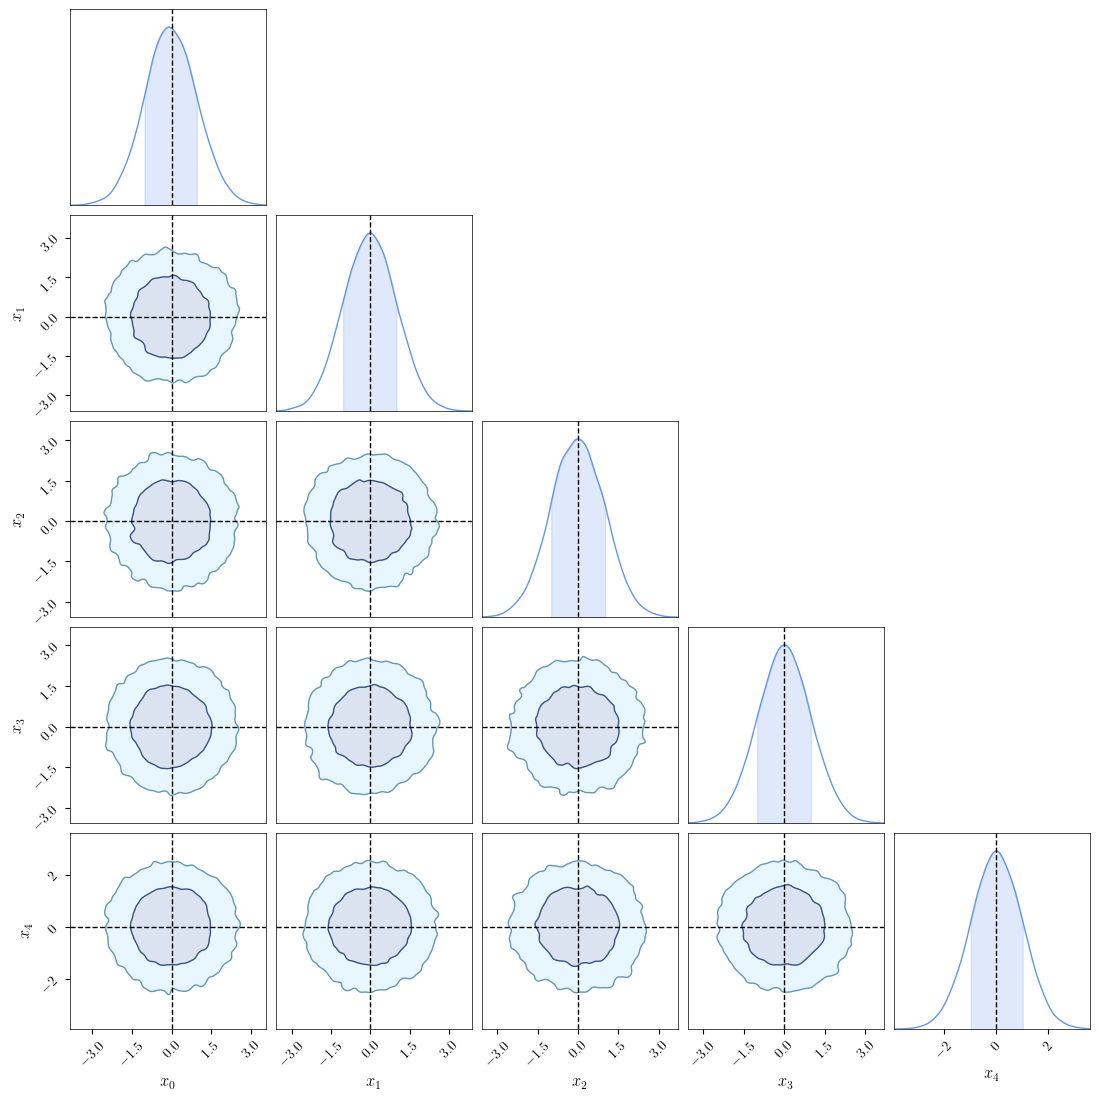

In [8]:
samples = ensemble.get_chain()['model_0'].reshape(-1, ndim)

c = ChainConsumer()
c.add_chain(samples, parameters=["$x_{}$".format(i) for i in range(ndim)], color='#6495ed')
c.configure(shade=True, shade_alpha=0.2, bar_shade=True, usetex=True)
c.plotter.plot(figsize=(12,12), truth=means);

# Or use the corner package
# corner.corner(samples, truths=means)

Now we will plot the chains.

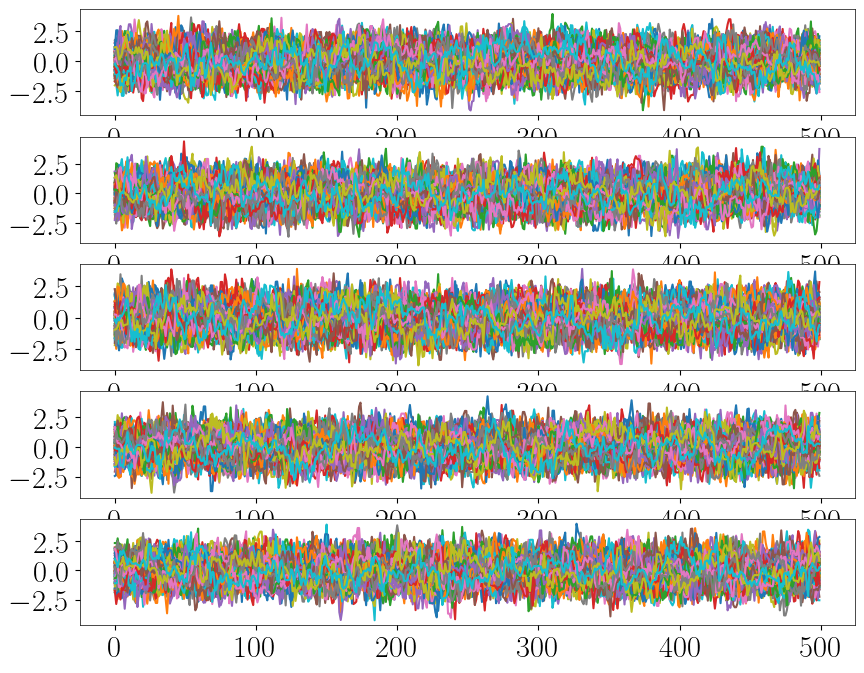

In [9]:
#### Chains
fig, ax = plt.subplots(ndim, 1, sharex=True)
fig.set_size_inches(13, 13)
for i in range(ndim):
    for walk in range(nwalkers):
        ax[i].plot(ensemble.get_chain()['model_0'][:, 0, walk, :, i])

## Backend Objects

Backends are where all of the information in the sampler is stored as it runs. It is from these backends that samples are retrieved for plotting. You can find the documentation for the Backend objects [here](https://mikekatz04.github.io/Eryn/html/user/backend.html#backends). Here, we will go through the most commonly used functions from the backend:
* `get_chain`: retrieve all of the samples stored over the course of the sampling run.
* `get_log_like`: retrieve the log of the Likelihood for each sample.
* `get_log_prior`: retrieve the log of the prior for each sample.
* `get_a_sample`: retrieve a state object from a specific iteration. `get_last_sample` may be more common. It is just a specific example of `get_a_sample` for the last sample.

Many (but not all) of the methods from the backend object are also raised to the level of sampler. So you can either call `EnsembleSampler.backend.method` or `EnsembleSampler.method` and it will be equivalent.

Common properties to get from the backend:
* `shape`: returns a dictionary with keys for each branch name and values as tuples representing the specific shape for each model (this shape will not include the `nsteps` outer dimension.
* `iteration`: number of stored iterations in the backend.

Now we will get the likelihood and prior. Notice the shape of the Likelihood is `(nsteps, ntemps, nwalkers)` (in this example we have 1 temperature). This will always be the shape of quantities that are a single value per walker (e.g. Likelihood, prior, posterior).

In [10]:
ll = ensemble.backend.get_log_like()
lp = ensemble.backend.get_log_prior()

print(f"Number of iterations {ensemble.backend.iteration}")
# equivalent to ensemble.get_log_like() and ensemble.get_log_prior()
print(ll.shape, ll, lp)

Number of iterations 500
(500, 1, 100) [[[-1.05297225 -2.81695595 -0.80839791 ... -1.30449907 -2.65001331
   -1.72492908]]

 [[-3.51878996 -0.89787788 -4.49356178 ... -4.65518146 -3.7436319
   -1.66068016]]

 [[-2.03059694 -1.49585829 -3.90577462 ... -1.04656098 -2.0396035
   -0.80658449]]

 ...

 [[-1.73887276 -2.27535667 -1.36789573 ... -1.19099689 -2.72232295
   -5.43958501]]

 [[-1.44427868 -1.05581352 -4.30749439 ... -1.85688564 -2.11343788
   -2.24766066]]

 [[-0.6654815  -2.28154314 -2.00102494 ... -1.6139005  -1.08899932
   -2.1398411 ]]] [[[-11.51292546 -11.51292546 -11.51292546 ... -11.51292546 -11.51292546
   -11.51292546]]

 [[-11.51292546 -11.51292546 -11.51292546 ... -11.51292546 -11.51292546
   -11.51292546]]

 [[-11.51292546 -11.51292546 -11.51292546 ... -11.51292546 -11.51292546
   -11.51292546]]

 ...

 [[-11.51292546 -11.51292546 -11.51292546 ... -11.51292546 -11.51292546
   -11.51292546]]

 [[-11.51292546 -11.51292546 -11.51292546 ... -11.51292546 -11.51292546
   -1

### 5-dimensional Arrays

The chain information is returned as a dictionary with keys as the branch names and values as 5-dimensional arrays: `(nsteps, ntemps, nwalkers, nleaves_max, ndim)`. For clarity:
* nsteps: number of sampler iterations stored (time evolution of each forest)
* ntemps: number of temperatures (which forest you are in)
* nwalkers: number of walkers (which tree)
* nleaves_max: maximum number of model counts or leaves for each specific branch.
* ndim: number of parameters describing a single model or leaf.

In our simple example, we have 1 temperature and our maximum leaf count is 1.

In [11]:
# getting the chain
samples = ensemble.get_chain()

# same as 
# samples = enseble.backend.get_chain()
print(type(samples), samples.keys(), samples["model_0"].shape)

<class 'dict'> dict_keys(['model_0']) (500, 1, 100, 1, 5)


We can also get the shape information direct from the backend:

In [12]:
ensemble.backend.shape

{'model_0': (1, 100, 1, 5)}

## State Objects

Now, we are going to look at [`State`](https://mikekatz04.github.io/Eryn/build/html/user/state.html#eryn.state.State) objects. They carry the current information throughout the sampler about the current state of the sampler. In our simple example, we can examine the current coordinates, likelihood, and prior values. 

Output from the sampler above is the last state of the sampler `out`. This will include any additional objects passed through the sampler like `BranchSupplimental` objects that we will explain below. 

Another way to retrieve the last state is from the backend. That is what we will do here. However, please note, that supplimental information (discussed below) is not stored in the backend, so the state that is returned from the backend will have information that is stored in the backend, but not supplimental information that was passed through the sampler at runtime. 

In [13]:
last_state = ensemble.backend.get_last_sample()
print(type(last_state))

<class 'eryn.state.State'>


We can access the Likelihood and prior values as `State.log_like` and `State.log_prior`. We can also ask the state to give use the posterior probability with the `get_log_prob` method. Note that shape of these values is `(ntemps, nwalkers)`. This is because `State` objects represent one moment in time in the sample, so they do not have the `nsteps` outer dimension that the backend has. 

In [14]:
print(out.log_like.shape, out.log_like, out.log_prior, out.get_log_prob())

(1, 100) [[-0.6654815  -2.28154314 -2.00102494 -4.41852808 -1.87391204 -3.05035603
  -1.47197889 -3.04722716 -3.8519063  -2.53028792 -1.47895075 -0.91435392
  -4.67615627 -6.59494035 -3.09579563 -2.31956089 -3.61486196 -1.12447462
  -2.1692713  -4.54813706 -5.47761491 -1.81600973 -2.57141612 -3.18369399
  -8.03114163 -4.03929851 -1.37835437 -1.41370852 -2.04192051 -4.24060107
  -1.81791365 -1.43145056 -1.01976309 -1.08419629 -3.29498179 -2.08090042
  -3.03457142 -0.97839311 -1.45783438 -0.54860516 -0.39096809 -1.63453914
  -2.05034555 -1.13275529 -2.13057916 -3.21847262 -2.14804885 -2.15556008
  -1.92686111 -1.99795709 -0.35164059 -1.21098077 -1.21647944 -1.15304968
  -3.4313149  -4.70693915 -1.4318716  -4.84488379 -2.02338003 -2.07328961
  -2.98861309 -1.0448529  -4.76536477 -1.86707428 -1.24040534 -1.52161672
  -0.93361207 -1.10290796 -1.69669336 -0.98189704 -5.90223547 -3.3408396
  -2.12094704 -3.14709346 -0.37990706 -1.48720061 -3.15361028 -1.1595534
  -1.80055637 -1.59197714 -3.34

### Branches

`State` objects store quantities at are single values per walker directly in the state as shown above (e.g. `State.log_like`). Information that gets down to the individual branch (or model type) level is stored in a [`Branch`](https://mikekatz04.github.io/Eryn/html/user/state.html#eryn.state.Branch) object. These `Branch` objects are stored in a dictionary within the `State` object with keys as branch names and values as the `Branch` object associated with that branch name. The branch objects can be accessed as `state.branches[model_name]`. With in the branch object, the coordinates are stored. A few other things are stored, but we will get to that later. If you want a dictionary with keys at the branch names and values as the current coordinates, you can also use the property: `state.branches_coords`.

In [15]:
last_state.branches

{'model_0': <eryn.state.Branch at 0x7fbaeabdd3d0>}

In [16]:
last_state.branches["model_0"].coords

# same as 
# last_state.branches_coords["model_0"]

array([[[[ 0.78336101, -0.50304083, -0.16554043,  0.38717246,
          -0.53567929]],

        [[ 1.67992539,  0.45789611,  0.71044046,  0.99561671,
          -0.18785587]],

        [[ 1.58942687, -0.98468048, -0.23409897, -0.34754982,
           0.5749637 ]],

        [[-1.51043746,  1.46761376, -1.36652826,  0.13575554,
           1.58616381]],

        [[ 0.56687718, -0.71412812, -1.07272873,  0.90290266,
          -0.9749437 ]],

        [[-0.26148892, -0.32754323,  2.05336273,  0.43505825,
           1.23267062]],

        [[-0.11388586,  0.97965383,  1.18803374, -0.55536628,
           0.50140833]],

        [[ 0.97231495, -1.80168105, -0.87750463,  0.55941876,
           0.9055604 ]],

        [[ 0.93206222,  0.61099548,  0.22893838, -0.06397951,
           2.53085973]],

        [[ 1.78123828,  0.29397075,  0.87720694, -0.51235873,
          -0.87712242]],

        [[-0.0915609 , -0.06094217,  0.39300579,  0.27838045,
          -1.6473782 ]],

        [[ 0.6848448 ,  0.373946

## Parallel Tempering

Adding tempering to our problem is straight forward. It will effectively just take the `ntemps` dimension that was 1 above and stretch it to the number of temperatures desired. We add tempering information by providing the `tempering_kwargs` argument to the `EnsembleSampler`. The tempering kwargs documentation can be found here because they are the `kwargs` that go into the initialization of the temperature controller: [`eryn.moves.tempering.TemperatureControl`](https://mikekatz04.github.io/Eryn/html/user/temper.html#eryn.moves.tempering.TemperatureControl).

The simplest thing to do is to provide the number of temperatures. In this case, we just pass `ntemps` in a dictionary. You can also provide a direct array of `betas` (inverse temperatures). Under the hood, if only `ntemps` is passed (not `betas`), the sampler will use the [`eryn.moves.tempering.make_ladder`](https://mikekatz04.github.io/Eryn/html/user/temper.html#eryn.moves.tempering.make_ladder) function. We will go all thr way through to the MCMC run. Notice that we are once again just passing `coords` as an array to start the sampling. We could also pass a `State` object.

What does tempering actual do? The inverse temperature, $\beta=1/T$, is attached as an exponent on the Likelihood. The posterior probability as a function of inverse temperature is given by,
$$\pi_\beta(\vec{\theta}, \mathcal{M})\propto (\mathcal{L}(\vec{\theta}, \mathcal{M}))^\beta p(\vec{\theta},\mathcal{M}).$$

If $T=1\rightarrow \beta=1$, we are probing our TARGET distribution. 

If $T=\infty\rightarrow \beta=0$, we are probing the PRIOR distribution. In this case, the Likelihood surface is effectively flat.  

Temperatures in between represent the gradual flattening of the target Likelihood surface towards the flat surface at infinite temperature. During sampling, we look at the log of the Likelihood, so the inverse temperature becomes a multiplicative factor:
$$\ln\pi_\beta(\vec{\theta}, \mathcal{M})\propto\beta\ln\mathcal{L}(\vec{\theta}, \mathcal{M})$$

Tempering is useful for multimodal distributions and to improve mixing in your chains. This mixing is created by swapping between rungs on our temperature ladder. After each sampler step, swaps are proposed starting at the two highest temperatures and iterating down until we reach the two lowest temperatures. This ensures as higher temperature chains find better Likelihood values, these values and positions are passed toward the cold chain ($\beta=1$). The swaps between chains are accepted with fraction, $\alpha_T$:
$$\alpha_T = \min\left(1, \left[\frac{\mathcal{L_{\beta_1}}}{\mathcal{L_{\beta_2}}}\right]^{\beta_1 - \beta_2}\right).$$

We can see from this how swapping is similar to the Metropolis-Hastings acceptance setup.If $\beta_1 > \beta_2$ (or $T_1  <T_2$), the exponent is positive. In this case, if $\mathcal{L_{\beta_1}} > \mathcal{L_{\beta_2}}$, the swap will always be accepted because we want the better likelihood to go to higher $\beta$ (or lower $T$). If $\mathcal{L_{\beta_1}} < \mathcal{L_{\beta_2}}$, the swap is accepted with a probability that reflects difference in the Likelihoods just like discussed above. 

In [17]:

# set up problem
ndim = 5
nwalkers = 100
ntemps = 10

# fill kwargs dictionary
tempering_kwargs=dict(ntemps=ntemps)

# randomize throughout prior
coords = priors.rvs(size=(ntemps, nwalkers,))

# initialize sampler
ensemble_pt = EnsembleSampler(
    nwalkers,
    ndim,
    log_like_fn,
    priors,
    args=[means, cov],
    tempering_kwargs=tempering_kwargs
)

nsteps = 500
# burn for 1000 steps
burn = 1000
# thin by 5
thin_by = 5
ensemble_pt.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)



100%|██████████| 2500/2500 [00:18<00:00, 138.46it/s]


We can plot our samples at different temperatures and see the differences in action. 

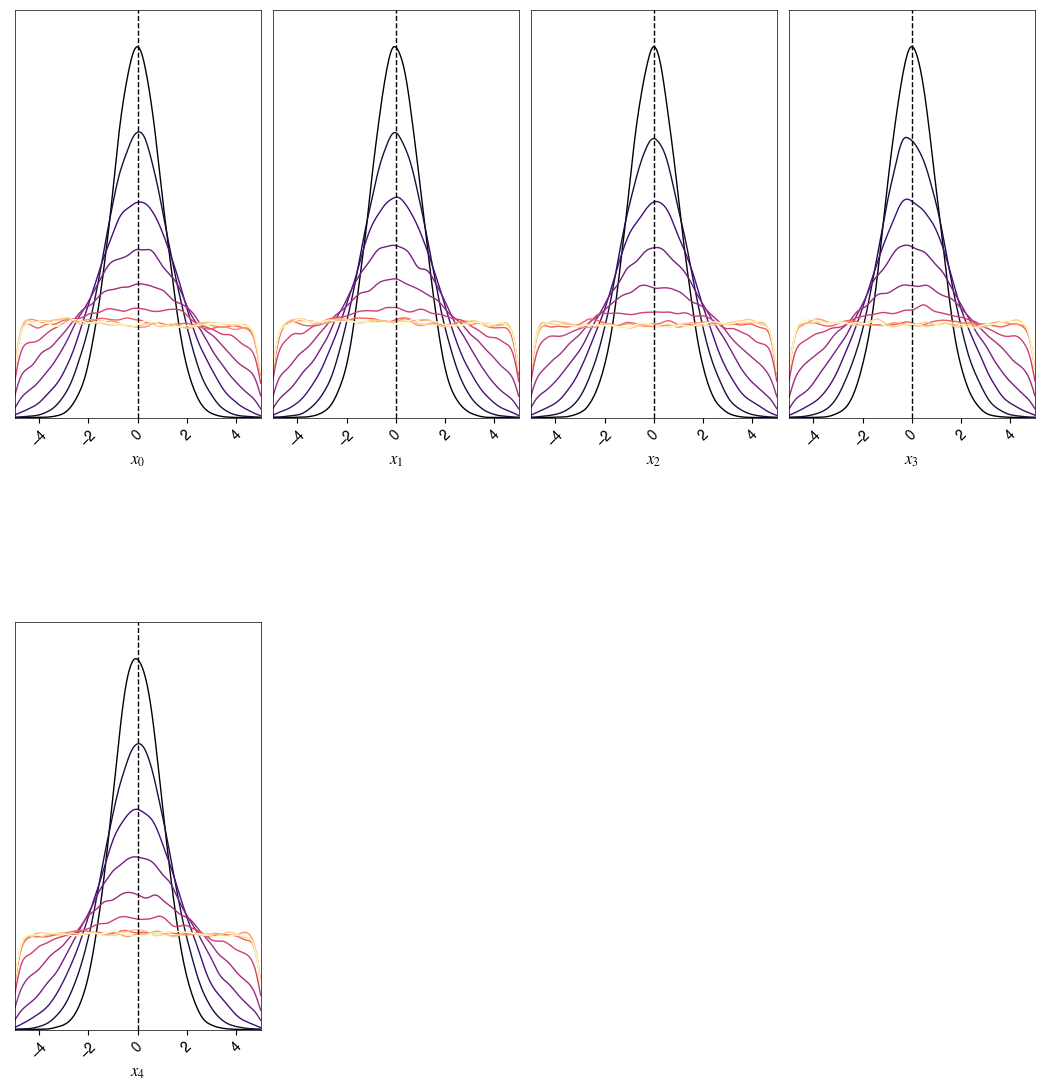

In [18]:
c = ChainConsumer()
c.configure(shade=True, shade_alpha=0.2, bar_shade=True, usetex=True)
colors = plt.cm.magma(np.linspace(0,1, ntemps))

for temp in range(ntemps):

    samples = ensemble_pt.get_chain()['model_0'][:, temp].reshape(-1, ndim)    
    c.add_chain(samples, parameters=["$x_{}$".format(i) for i in range(ndim)], color=colors[temp], name="$T_{}$".format(temp))

c.plotter.plot_distributions(figsize=(12,12), truth=np.full(ndim, 0.0));
mpl.rcParams['text.usetex']=True # Update this becasue chaincnsumer is annoying

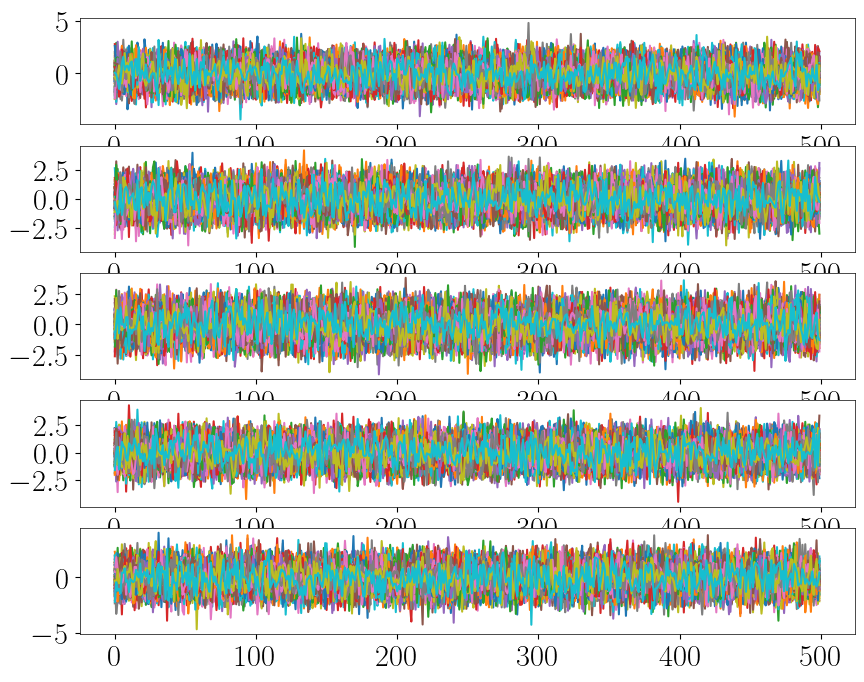

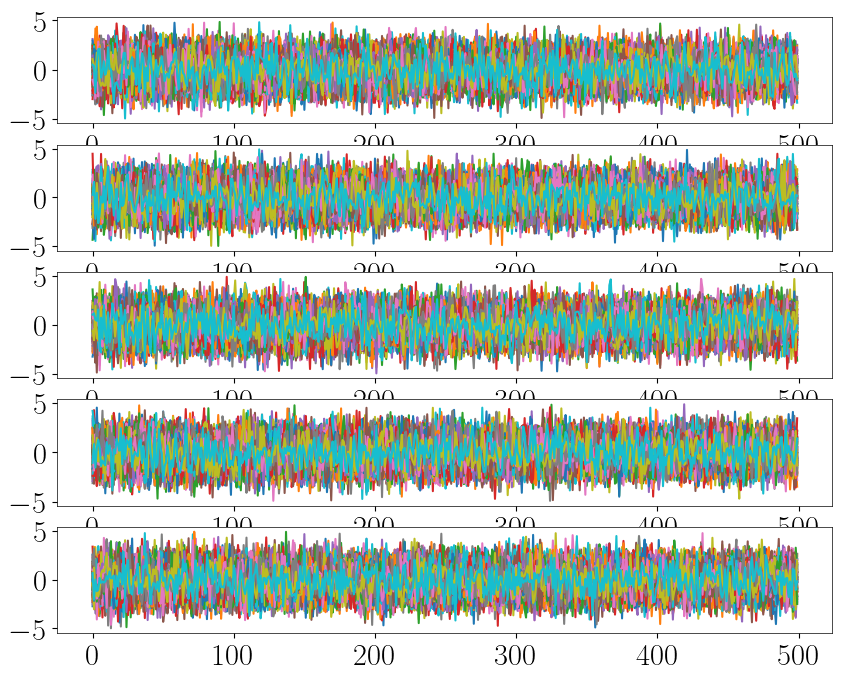

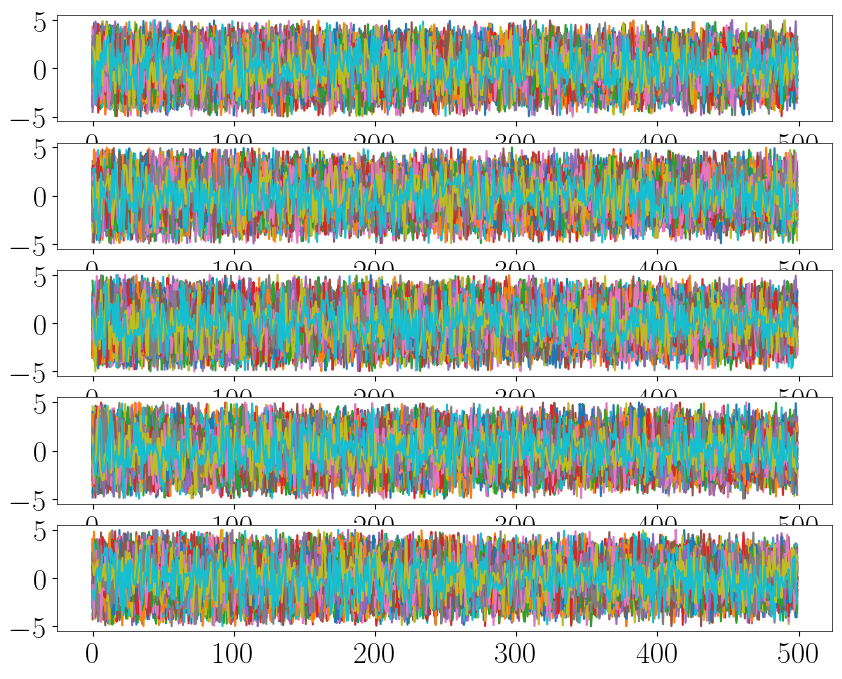

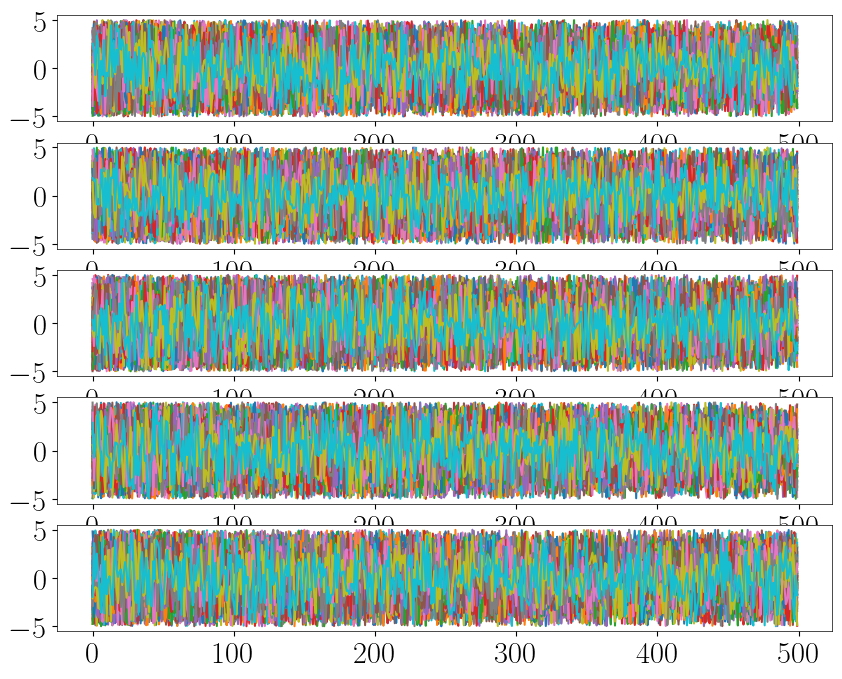

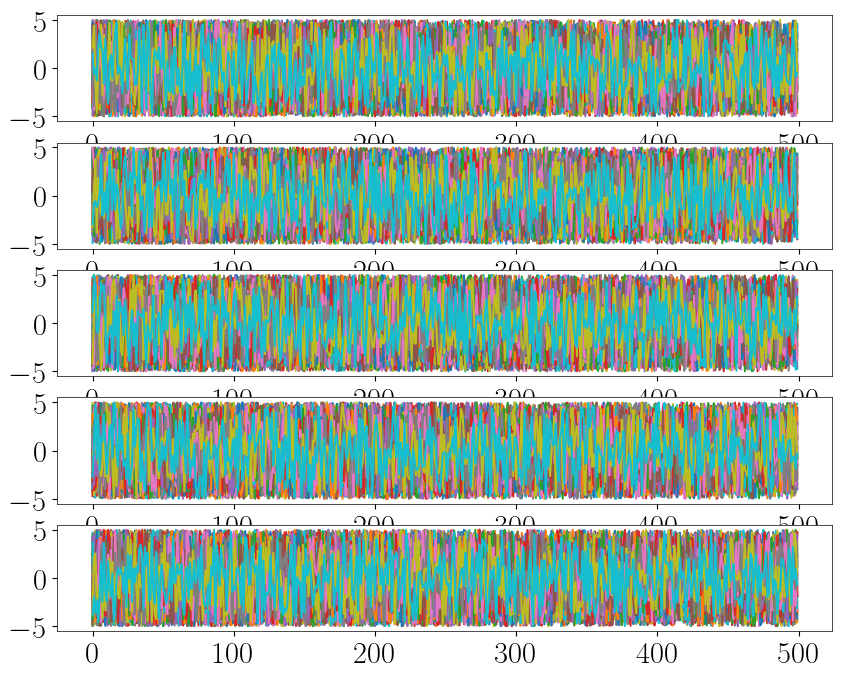

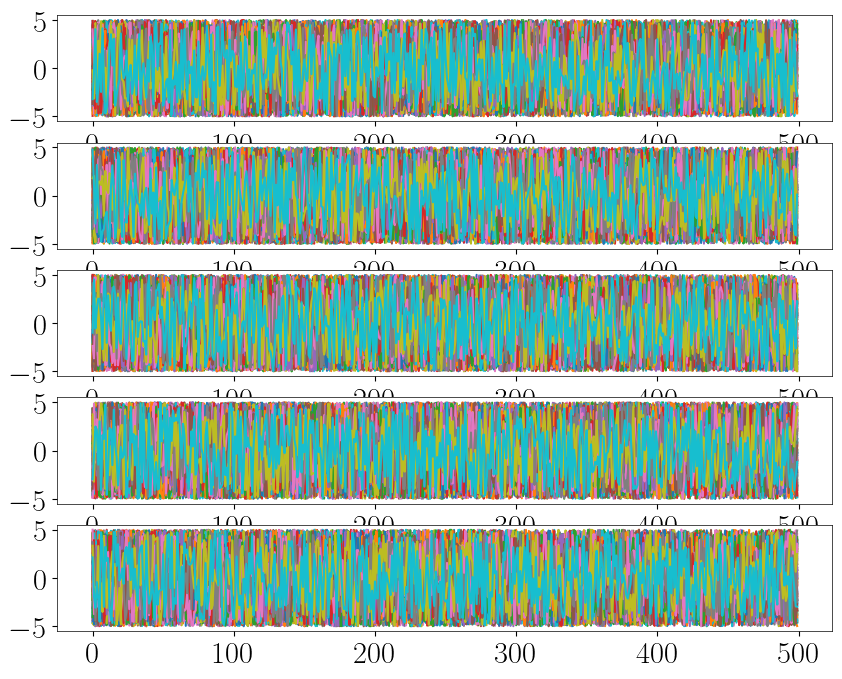

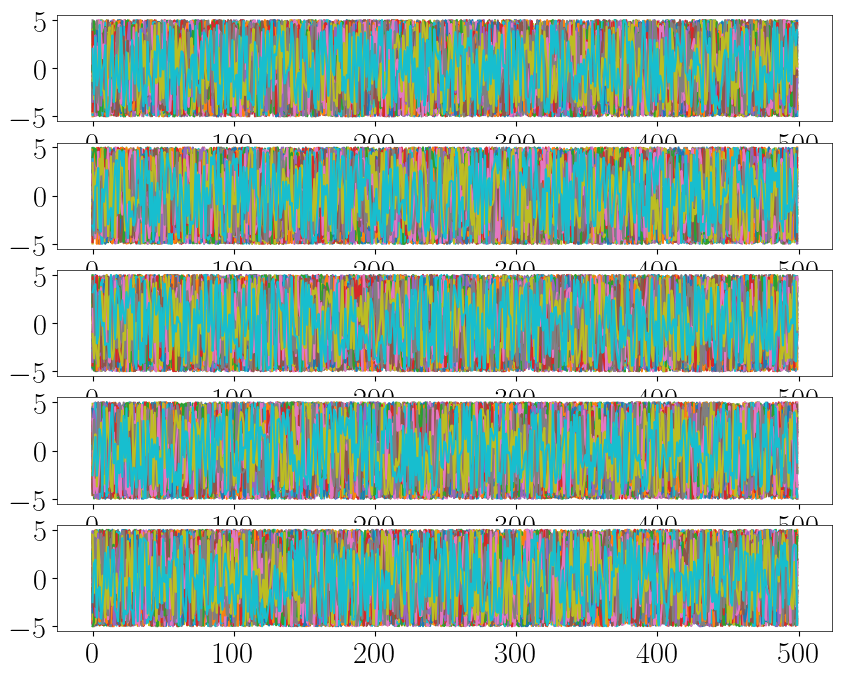

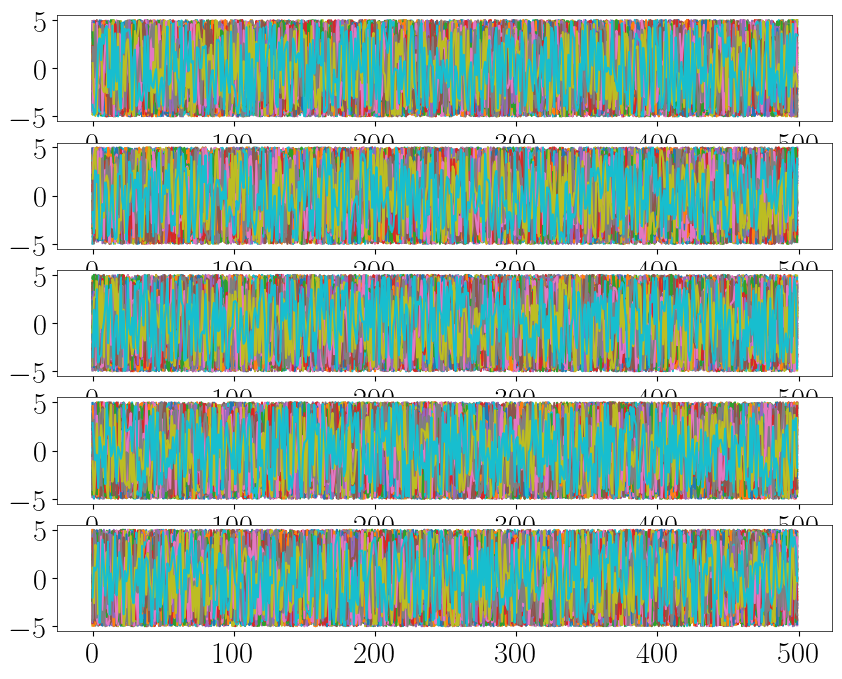

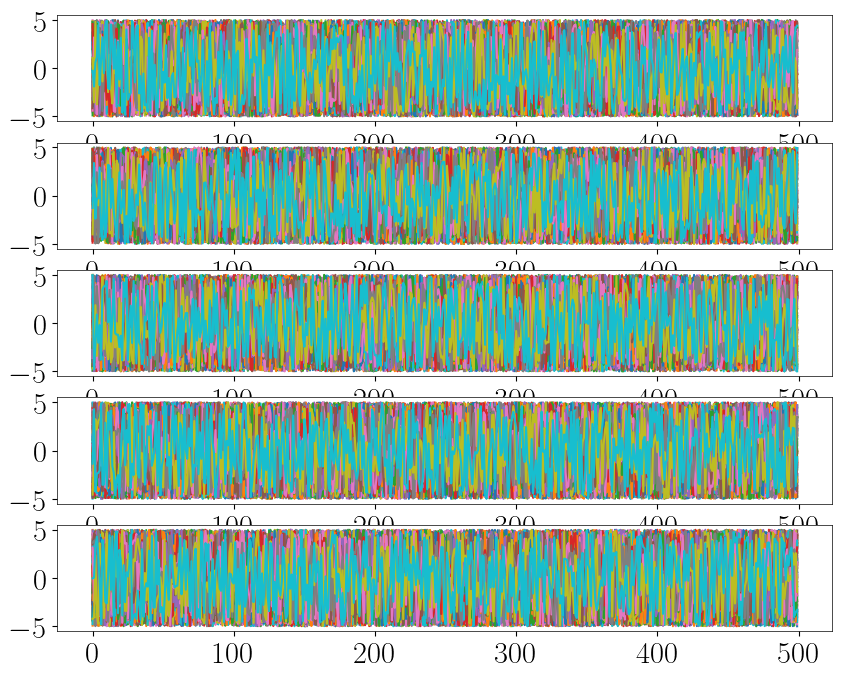

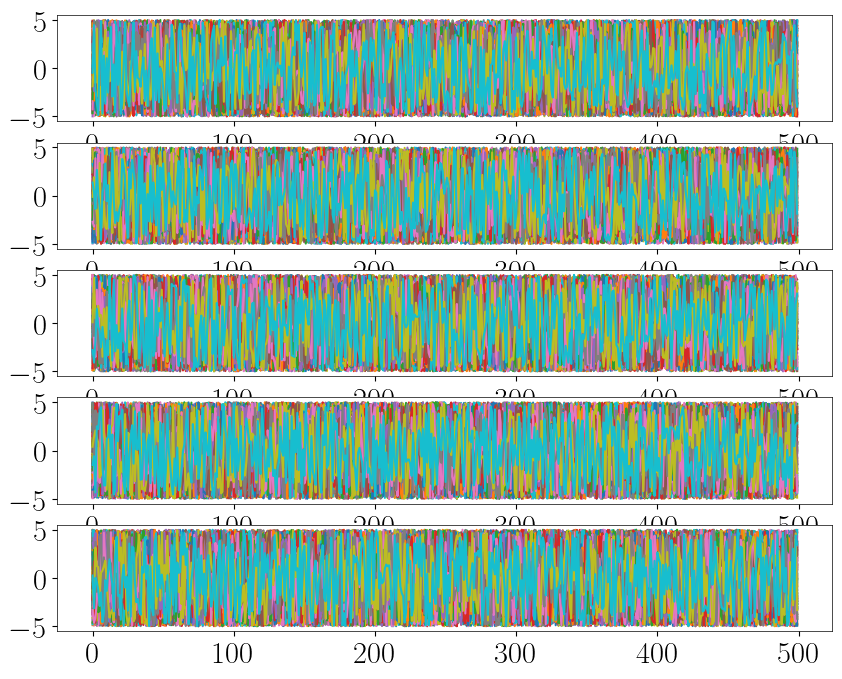

In [19]:
#### Chains
for temp in range(ntemps):
    fig, ax = plt.subplots(ndim, 1, sharex=True)
    fig.set_size_inches(13, 13)
    for i in range(ndim):
        for walk in range(nwalkers):
            ax[i].plot(ensemble_pt.get_chain()['model_0'][:, temp, walk, :, i])

Likelihoods across temperatures:

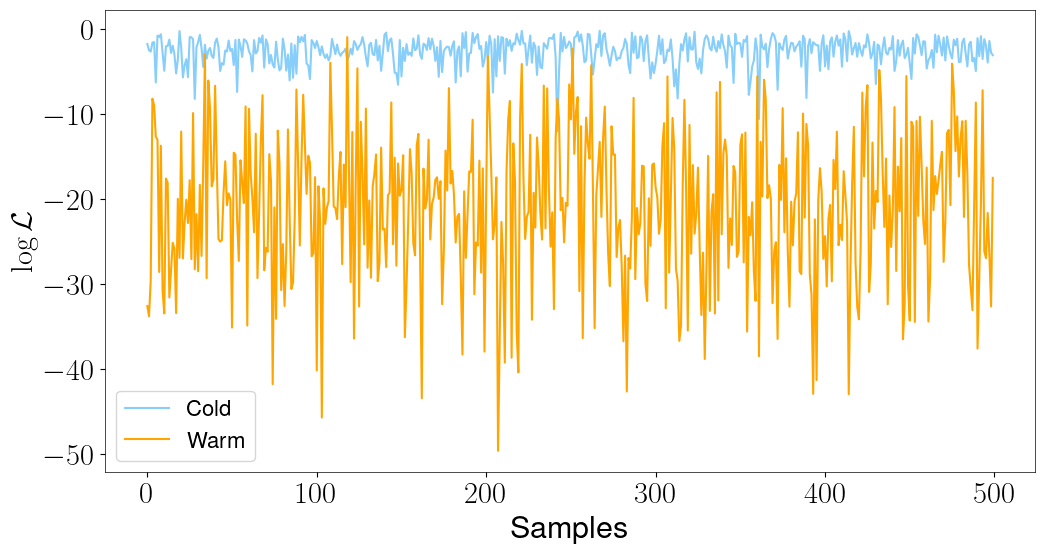

In [20]:
ll = ensemble_pt.backend.get_log_like()

# cold chain and highest temperature chain
plt.figure(figsize=(12,6))
plt.plot(ll[:, 0, 0], label="Cold", color='lightskyblue')
plt.plot(ll[:, -1, 0], label="Warm", color='orange')
plt.xlabel("Samples")
plt.ylabel("$\log\mathcal{L}$")
plt.legend()
plt.show()

## Add Reversible Jump MCMC (model count uncertainty)

We will now add to our sampler the ability to run with one branch, but a variable number of counts or leaves. 

Here we are going to focus on the nested model case where we are just proposing changes in the model count. For more general review on Reversible Jump, see the Eryn paper and sources within. 

In nested models, the acceptance probability for proposing to add a source is given by, $\alpha_\text{nested}$,
$$ \alpha_\text{nested} = \min\left(1, \frac{\mathcal{L}(\vec{\theta})_{k+1}}{\mathcal{L}(\vec{\theta})_{k}}\frac{p(\vec{\theta}_{+1})}{q(\vec{\theta}_{+1})}\right), $$
where there are $k$ models to start, $p(\vec{\theta}_{+1})$ is the prior probability of the added source only (the prior of the other sources cancels in the numerator and denominator), and $q(\vec{\theta}_{+1})$ is the proposal distribution for the added source, $\mathcal{L}(\vec{\theta})_k$ is the Likelihood for the position with $k$ models, and $\mathcal{L}(\vec{\theta})_{k+1}$ is the Likelihood for the position with $k + 1$ models.

Reversible Jump proposals usually require specific implementations for each problem. We have one provided RJ proposal where we draw from the prior, which is the simplest and most generic reversible jump proposal for adding a nested model. In this case, the acceptance fraction just reduces to the Likelihood fraction. 


For this example, we will look at a set of 1D Gaussian pulses. We will inject a specific number, and then allow the sampler to determine the posterior probability on the model count, as well as the posterior on the parameters. 

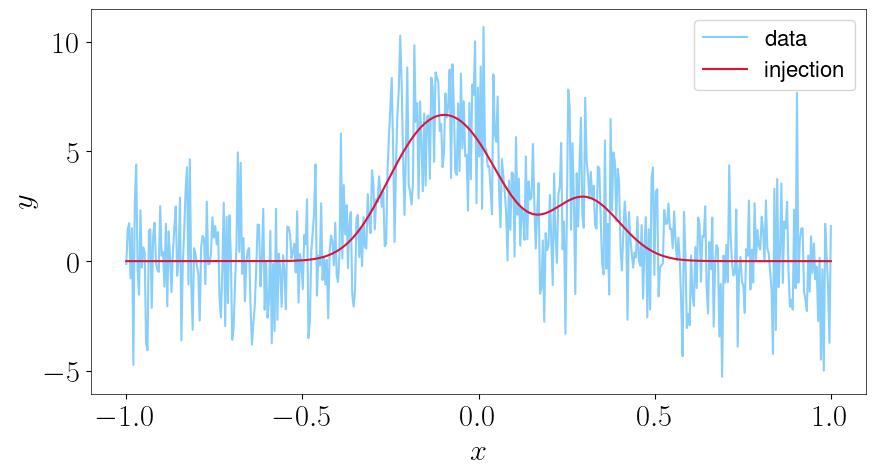

In [21]:
def gaussian_pulse(x, a, b, c):
    f_x = a * np.exp(-((x - b) ** 2) / (2 * c ** 2))
    return f_x

def combine_gaussians(t, params):
    template = np.zeros_like(t)
    for param in params:
        template += gaussian_pulse(t, *param)  # *params -> a, b, c
    return template

def log_like_fn_gauss_pulse(params, t, data, sigma):
    
    template = combine_gaussians(t, params)
    
    ll = -0.5 * np.sum(((template - data) / sigma) ** 2, axis=-1)
    return ll


nwalkers = 20
ntemps = 8
ndim = 3
nleaves_max = 8
nleaves_min = 0

branch_names = ["gauss"]

# define time stream
num = 500
t = np.linspace(-1, 1, num)

gauss_inj_params = [
    [3.3, -0.2, 0.1],
    [2.6, -0.1, 0.1],
    [3.4, 0.0, 0.1],
    [2.9, 0.3, 0.1],
]

# combine gaussians
injection = combine_gaussians(t, np.asarray(gauss_inj_params))

# set noise level
sigma = 2.0

# produce full data
y = injection + sigma * np.random.randn(len(injection))

plt.figure(figsize=(10,5))
plt.plot(t, y, label="data", color="lightskyblue")
plt.plot(t, injection, label="injection", color="crimson")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()

#### Setup our reversible-jump run

The first thing we do is setup our `coords` array. We have seen `coords` before. That array is the same but now `nleaves_max > 1`.  

We also need to setup our `inds` arrays. `inds` is only needed when the dimensionality is changing (or more generally when not all leaves are used). `inds` is a boolean array with shape `(ntemps, nwalkers, nleaves_max)`. It indicates which leaves are being used. This allows us to use the array structures while have a variable number of leaves per walker. 

We are going to assume we have some knowledge of what is in the data, so we are going to start with 4 leaves for every walker. The burn-in will spread out the walkers both in terms of the parameters and in terms of the number of leaves per walker. Therefore, we are going to make the first four leaves in every walker `True` to indicate 4 sources. We are going to then put coordinates near each of the true Gaussians into `coords`.

In [22]:
coords = {"gauss": np.zeros((ntemps, nwalkers, nleaves_max, ndim))}

# this is the sigma for the multivariate Gaussian that sets starting points
# We need it to be very small to assume we are passed the search phase
# we will verify this is with likelihood calculations
sig1 = 0.0001

# setup initial walkers to be the correct count (it will spread out)
for nn in range(nleaves_max):
    if nn >= len(gauss_inj_params):
        # not going to add parameters for these unused leaves
        continue
        
    coords["gauss"][:, :, nn] = np.random.multivariate_normal(gauss_inj_params[nn], np.diag(np.ones(3) * sig1), size=(ntemps, nwalkers)) 

# make sure to start near the proper setup
inds = {"gauss": np.zeros((ntemps, nwalkers, nleaves_max), dtype=bool)}

# turn False -> True for any binary in the sampler
inds['gauss'][:, :, :len(gauss_inj_params)] = True

Priors are defined per model for a single model. It will take into account multiple models by summing the prior probability over the leaves.

In [23]:
# describes priors for all leaves independently
priors = {
    "gauss": {
        0: uniform_dist(2.5, 3.5),  # amplitude
        1: uniform_dist(t.min(), t.max()),  # mean 
        2: uniform_dist(0.01, 0.21),  # sigma
    },
}

When reversible jump sampling is run, an RJ move (between model) is performed followed by an "in-model" move for each iteration of the sampler. "In-model" here means the model count is fixed, but the parameters are updated. We pass "in-model" moves to the sampler with the keyword argument `moves`. We pass RJ moves with the `rj_moves` keyword argument. 

The stock proposal in `Eryn` is the stretch proposal. This proposal is only directly useful when the dimensionality is fixed. This will be discussed more below. When using reversible jump, we must choose our in-model proposal because the dimensionality is not fixed. Therefore, we choose to move our walkers with the most basic in-model move available: [`eryn.moves.GaussianMove`](https://mikekatz04.github.io/Eryn/html/user/moves.html#eryn.moves.GaussianMove). For this move you can provide a covariance matrix that will be used in a multivariate Gaussian to propose new points that are centered on the current points (the means of the multivariate Gaussian will be the current point). This proposal is symmetric. 

In this case, we are going to use the stock RJ proposal: [`eryn.moves.PriorGenRj`](https://mikekatz04.github.io/Eryn/html/user/moves.html#eryn.moves.DistributionGenerateRJ). You can either pass this directly or you can set `rj_moves` to `True` (this is the default). 

In [24]:
# for the Gaussian Move, will be explained later
factor = 0.00001
cov = {"gauss": np.diag(np.ones(ndim)) * factor}

moves = GaussianMove(cov)


We will now initialize the sampler by adding the branch, tempering, leaf, and move information.

In [25]:
ensemble = EnsembleSampler(
    nwalkers,
    ndim,  
    log_like_fn_gauss_pulse,
    priors,
    args=[t, y, sigma],
    tempering_kwargs=dict(ntemps=ntemps),
    nbranches=len(branch_names),
    branch_names=branch_names,
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min,
    moves=moves,
    rj_moves=True,  # basic generation of new leaves from the prior
)



Now we will setup a `State` object and will use the Likelihood (`compute_log_like`) and prior functions (`compute_log_prior`) that are built into the sampler. The Likelihood function in the sampler will check the prior and only run walkers that exist entirely within the prior distribution. We can avoid redoing this computation by passing the prior as the `logp` kwarg to `compute_log_like`. The `[0]` at the end of the line is to grab the log Likelihood and leave behind any blobs. 

In [26]:

log_prior = ensemble.compute_log_prior(coords, inds=inds)
log_like = ensemble.compute_log_like(coords, inds=inds, logp=log_prior)[0]

# make sure it is reasonably close to the maximum which this is
# will not be zero due to noise
print(log_like, log_prior)

# setup starting state
state = State(coords, log_like=log_like, log_prior=log_prior, inds=inds)


[[-267.48857258 -273.13358068 -272.04356318 -273.41959181 -269.65159976
  -273.45581292 -269.0534354  -269.21480317 -270.17335397 -268.79114293
  -267.97593006 -269.76118281 -268.97477874 -268.96915067 -267.44497304
  -268.55232307 -268.69079155 -269.13611008 -266.317588   -268.19035794]
 [-267.89498107 -271.07519263 -271.01364247 -269.87074404 -271.04982746
  -273.10216287 -270.47561552 -268.73825004 -268.55984235 -267.59669384
  -269.1644275  -268.17686823 -269.5530668  -266.38471516 -270.13810357
  -268.4965744  -271.16336376 -268.37273575 -269.78843561 -266.07926996]
 [-266.65635127 -268.4524668  -269.58696913 -269.88671242 -266.37498437
  -266.44936502 -266.4546787  -272.25432486 -269.746439   -273.53395912
  -268.78432036 -268.09641939 -269.51993913 -270.03690593 -268.47293353
  -270.13166208 -267.3654575  -272.4533991  -267.76589766 -268.67119754]
 [-268.70301053 -268.05419472 -266.85429247 -268.34706671 -272.61170665
  -270.35744037 -267.49130951 -266.41191836 -275.34555909 -26

Run the sampler

In [27]:
nsteps = 2000
last_sample = ensemble.run_mcmc(state, nsteps, burn=1000, progress=True, thin_by=1)


 48%|████▊     | 478/1000 [00:08<00:09, 57.05it/s]Traceback (most recent call last):
  File "/Users/nikos/work/programs/anaconda3/lib/python3.9/site-packages/eryn/ensemble.py", line 1430, in __call__
    out = self.f(*args_in, **kwargs_in)
  File "/var/folders/yz/xf637mpx56g2dvdv9d8v1fnm0000gn/T/ipykernel_80778/341605811.py", line 13, in log_like_fn_gauss_pulse
    template = combine_gaussians(t, params)
  File "/var/folders/yz/xf637mpx56g2dvdv9d8v1fnm0000gn/T/ipykernel_80778/341605811.py", line 8, in combine_gaussians
    template += gaussian_pulse(t, *param)  # *params -> a, b, c
  File "/var/folders/yz/xf637mpx56g2dvdv9d8v1fnm0000gn/T/ipykernel_80778/341605811.py", line 2, in gaussian_pulse
    f_x = a * np.exp(-((x - b) ** 2) / (2 * c ** 2))
KeyboardInterrupt
 48%|████▊     | 480/1000 [00:08<00:09, 56.01it/s]


eryn: Exception while calling your likelihood function:
  args added: [array([[ 3.20995857, -0.09259871,  0.13038718]])]
  args: [array([-1.        , -0.99599198, -0.99198397, -0.98797595, -0.98396794,
       -0.97995992, -0.9759519 , -0.97194389, -0.96793587, -0.96392786,
       -0.95991984, -0.95591182, -0.95190381, -0.94789579, -0.94388778,
       -0.93987976, -0.93587174, -0.93186373, -0.92785571, -0.9238477 ,
       -0.91983968, -0.91583166, -0.91182365, -0.90781563, -0.90380762,
       -0.8997996 , -0.89579158, -0.89178357, -0.88777555, -0.88376754,
       -0.87975952, -0.8757515 , -0.87174349, -0.86773547, -0.86372745,
       -0.85971944, -0.85571142, -0.85170341, -0.84769539, -0.84368737,
       -0.83967936, -0.83567134, -0.83166333, -0.82765531, -0.82364729,
       -0.81963928, -0.81563126, -0.81162325, -0.80761523, -0.80360721,
       -0.7995992 , -0.79559118, -0.79158317, -0.78757515, -0.78356713,
       -0.77955912, -0.7755511 , -0.77154309, -0.76753507, -0.76352705,
      

KeyboardInterrupt: 

Let's look at the last sample in terms of the `nleaves` array. 

In [ ]:
last_sample.branches["gauss"].nleaves

array([[4, 5, 4, 4, 5, 4, 3, 4, 4, 5, 4, 3, 4, 5, 4, 3, 4, 4, 4, 4],
       [3, 4, 3, 3, 4, 4, 3, 4, 3, 4, 5, 5, 3, 4, 3, 3, 4, 3, 4, 4],
       [3, 3, 3, 5, 3, 3, 4, 4, 4, 5, 3, 3, 4, 4, 3, 4, 3, 3, 3, 3],
       [2, 3, 3, 4, 3, 4, 4, 4, 3, 4, 3, 3, 4, 4, 4, 4, 3, 2, 3, 4],
       [5, 2, 4, 4, 3, 2, 3, 3, 3, 3, 4, 4, 2, 4, 5, 3, 3, 3, 4, 2],
       [3, 3, 4, 3, 6, 3, 3, 4, 3, 3, 5, 3, 3, 4, 3, 4, 5, 3, 3, 2],
       [2, 2, 2, 5, 2, 4, 3, 2, 2, 5, 4, 4, 6, 6, 3, 3, 1, 3, 4, 3],
       [1, 6, 2, 4, 7, 7, 5, 3, 1, 6, 2, 7, 1, 2, 3, 5, 3, 3, 6, 6]])

max ll: -261.23462233367997


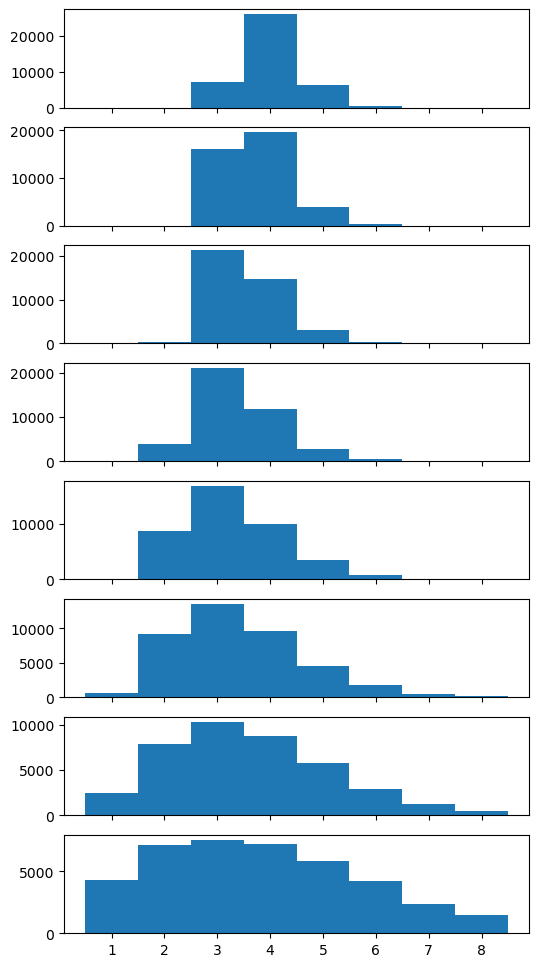

In [ ]:
print(f'max ll: {ensemble.get_log_like().max()}')

nleaves = ensemble.get_nleaves()['gauss']
bns = (
    np.arange(1, nleaves_max + 2) - 0.5
)  # Just to make it pretty and center the bins

colors = plt.cm.magma(np.linspace(0,1, ntemps))

fig, ax = plt.subplots(ntemps, 1, sharex=True)
fig.set_size_inches(6, 12)
for temp, ax_t in enumerate(ax):
    ax_t.hist(nleaves[:, temp].flatten(), bins=bns, color=colors[temp], density=True)
ax_t.set_xlabel("Order $k$ of model")

To get the samples, we need remove any sources that were not used. We can combine `coords` and `inds` or we can remove anywhere where the backend returns `Nan`. Backends store `Nan` for the coordinates that belong to sources that are not currently used (`inds == False`).

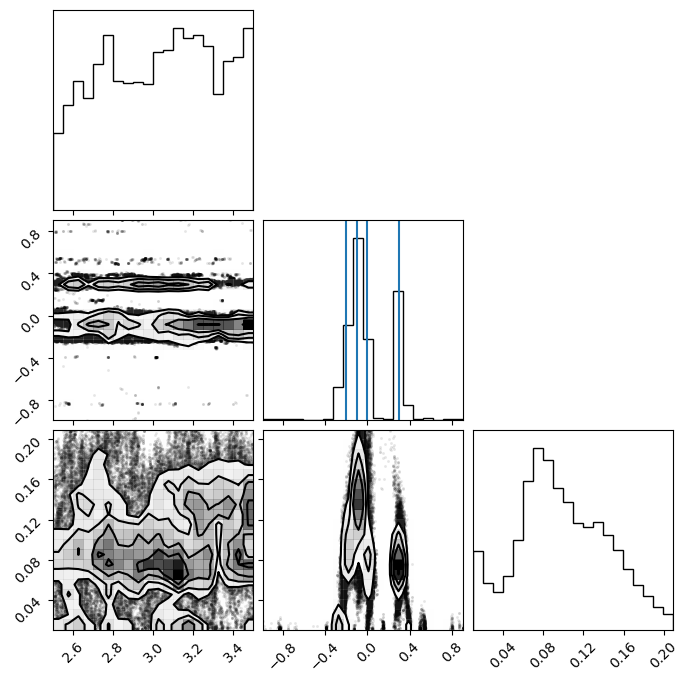

In [ ]:
samples = ensemble.get_chain()['gauss'][:, 0].reshape(-1, ndim)

# same as ensemble.get_chain()['gauss'][ensemble.get_inds()['gauss']]
samples = samples[~np.isnan(samples[:, 0])]

means = np.asarray(gauss_inj_params)[:, 1]

param_names = ['$A$', '$\mu$', '$\sigma$']

c = ChainConsumer()
c.add_chain(samples, parameters=param_names, color='#6495ed')
c.configure(shade=True, shade_alpha=0.2, bar_shade=True, usetex=True, serif=True)
for ii in range(len(gauss_inj_params)):
    c.add_marker(gauss_inj_params[ii], parameters=param_names, marker_style="x", marker_size=100, color='#DC143C')

c.plotter.plot(figsize=(8,8), legend=False);
mpl.rcParams['text.usetex']=True # Update this becasue chaincnsumer is annoying

## Add multiple branches

Now we will add another model to our reversible jump problem. We will add a sine wave model.

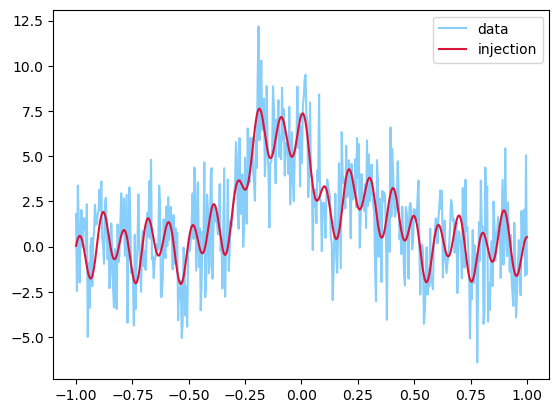

In [ ]:
def gaussian_pulse(x, a, b, c):
    f_x = a * np.exp(-((x - b) ** 2) / (2 * c ** 2))
    return f_x

def combine_gaussians(t, params):
    template = np.zeros_like(t)
    for param in params:
        template += gaussian_pulse(t, *param)  # *params -> a, b, c
    return template

def sine(x, a, b, c):
    f_x = a * np.sin(2 * np.pi * b * x + c)
    return f_x

def combine_sine(t, params):
    template = np.zeros_like(t)
    for param in params:
        template += sine(t, *param)  # *params -> a, b, c
    return template

def log_like_fn_gauss_and_sine(params_both, t, data, sigma):
    
    params_gauss, params_sine = params_both
    template = np.zeros_like(t)
    
    if params_gauss is not None:
        template += combine_gaussians(t, params_gauss)
        
    if params_sine is not None:
        template += combine_sine(t, params_sine)
    
    ll = -0.5 * np.sum(((template - data) / sigma) ** 2, axis=-1)
    return ll


nwalkers = 20
ntemps = 8
ndims = [3, 3]
nleaves_max = [8, 4]
nleaves_min = [0, 0]

branch_names = ["gauss", "sine"]

# define time stream
num = 500
t = np.linspace(-1, 1, num)

gauss_inj_params = [
    [3.3, -0.2, 0.1],
    [2.6, -0.1, 0.1],
    [3.4, 0.0, 0.1],
    [2.9, 0.3, 0.1],
]

sine_inj_params = [
    [1.3, 10.1, 1.0],
    [0.8, 4.6, 1.2],
]

# combine gaussians
injection = combine_gaussians(t, np.asarray(gauss_inj_params))
injection += combine_sine(t, np.asarray(sine_inj_params))

# set noise level
sigma = 2.0

# produce full data
y = injection + sigma * np.random.randn(len(injection))

plt.figure(figsize=(10,5))
plt.plot(t, y, label="data", color="lightskyblue")
plt.plot(t, injection, label="injection", color="crimson")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()

`coords` and `inds`

In [ ]:
coords = {
    "gauss": np.zeros((ntemps, nwalkers, nleaves_max[0], ndims[0])),
    "sine": np.zeros((ntemps, nwalkers, nleaves_max[1], ndims[1]))
}

# make sure to start near the proper setup
inds = {
    "gauss": np.zeros((ntemps, nwalkers, nleaves_max[0]), dtype=bool),
    "sine": np.zeros((ntemps, nwalkers, nleaves_max[1]), dtype=bool)
}


# this is the sigma for the multivariate Gaussian that sets starting points
# We need it to be very small to assume we are passed the search phase
# we will verify this is with likelihood calculations
sig1 = 0.0001

# setup initial walkers to be the correct count (it will spread out)
# start with gaussians
for nn in range(nleaves_max[0]):
    if nn >= len(gauss_inj_params):
        # not going to add parameters for these unused leaves
        continue
    coords["gauss"][:, :, nn] = np.random.multivariate_normal(gauss_inj_params[nn], np.diag(np.ones(3) * sig1), size=(ntemps, nwalkers)) 
    inds["gauss"][:, :, nn] = True
    
# next do sine waves
for nn in range(nleaves_max[1]):
    if nn >= len(sine_inj_params):
        # not going to add parameters for these unused leaves
        continue
    coords["sine"][:, :, nn] = np.random.multivariate_normal(sine_inj_params[nn], np.diag(np.ones(3) * sig1), size=(ntemps, nwalkers)) 
    inds["sine"][:, :, nn] = True


Priors are defined per model for a single model. It will take into account multiple models by summing the prior probability over the leaves.

In [ ]:
# describes priors for all leaves independently
priors = {
    "gauss": {
        0: uniform_dist(2.5, 3.5),  # amplitude
        1: uniform_dist(t.min(), t.max()),  # mean 
        2: uniform_dist(0.01, 0.21),  # sigma
    },
    "sine": {
        0: uniform_dist(0.5, 1.5),  # amplitude
        1: uniform_dist(1., 20.),  # mean 
        2: uniform_dist(0.0, 2 * np.pi),  # sigma
    },
}

You can add multiple covariance matrices. One for each branch. We will keep it the same for simplicity. 

In [ ]:
# for the Gaussian Move, will be explained later
factor = 0.00001
cov = {
    "gauss": np.diag(np.ones(ndims[0])) * factor,
    "sine": np.diag(np.ones(ndims[1])) * factor
}

moves = GaussianMove(cov)


We will now initialize the sampler by adding the branch, tempering, leaf, and move information.

In [ ]:
ensemble = EnsembleSampler(
    nwalkers,
    ndims,  
    log_like_fn_gauss_and_sine,
    priors,
    args=[t, y, sigma],
    tempering_kwargs=dict(ntemps=ntemps),
    nbranches=len(branch_names),
    branch_names=branch_names,
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min,
    moves=moves,
    rj_moves=True,  # basic generation of new leaves from the prior
)



Prior, Likelihood, and initial state.

In [ ]:

log_prior = ensemble.compute_log_prior(coords, inds=inds)
log_like = ensemble.compute_log_like(coords, inds=inds, logp=log_prior)[0]

# make sure it is reasonably close to the maximum which this is
# will not be zero due to noise
print(log_like, log_prior)

# setup starting state
state = State(coords, log_like=log_like, log_prior=log_prior, inds=inds)


[[-234.53942834 -231.02130265 -232.90013003 -234.27506945 -234.66049471
  -238.07444275 -232.35687664 -231.33282587 -233.67086092 -238.11812911
  -233.20893301 -234.09371576 -234.35950776 -232.22459072 -232.06633741
  -235.14924797 -233.03502571 -234.18734006 -230.51431626 -232.61219376]
 [-231.84785934 -232.4996235  -234.89660657 -231.47214529 -232.43293087
  -233.62747615 -235.48686245 -235.88505379 -232.81529148 -234.000288
  -231.88576696 -232.18827551 -232.3379514  -231.98159959 -231.42321303
  -234.82683865 -239.88225406 -234.38151288 -233.2526001  -234.0482375 ]
 [-232.11299528 -233.91930072 -231.67132705 -233.62788986 -236.69915292
  -232.67648092 -234.48131299 -232.3694508  -238.60185876 -234.52455906
  -232.31049587 -234.91272623 -234.02915306 -237.34052966 -231.34264015
  -232.75469102 -232.51230222 -233.28482696 -232.04417766 -232.68530641]
 [-234.98873196 -232.27022538 -234.02160702 -232.6097875  -233.12256479
  -232.51232655 -232.38305872 -234.39744761 -232.54456678 -241.

Run the sampler

In [ ]:
state.branches

{'gauss': <eryn.state.Branch at 0x169d9d4c0>,
 'sine': <eryn.state.Branch at 0x169d9d100>}

In [ ]:
nsteps = 5000
last_sample = ensemble.run_mcmc(state, nsteps, burn=1000, progress=True, thin_by=1)


100%|███████████████████████████████████████| 5000/5000 [03:42<00:00, 22.49it/s]


Let's look at the last sample in terms of the `nleaves` array for both branches in the cold chain. 

In [ ]:
np.array([last_sample.branches["gauss"].nleaves[0], last_sample.branches["sine"].nleaves[0]]).T

array([[4, 2],
       [3, 3],
       [4, 2],
       [4, 2],
       [4, 2],
       [4, 2],
       [4, 2],
       [4, 2],
       [4, 2],
       [4, 2],
       [4, 2],
       [4, 2],
       [4, 2],
       [4, 2],
       [4, 2],
       [4, 2],
       [4, 2],
       [4, 2],
       [4, 2],
       [3, 3]])

max ll: -224.91812775874538


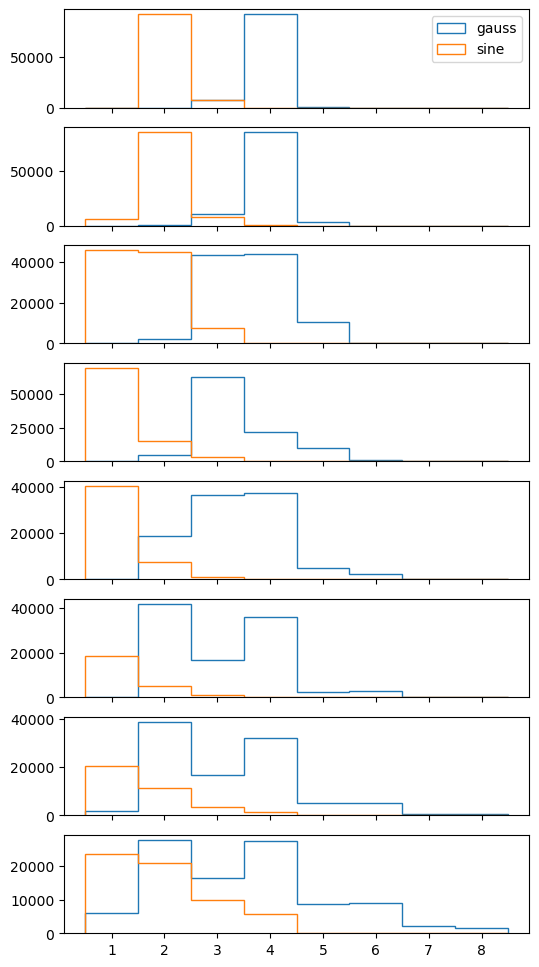

In [ ]:
print(f'max ll: {ensemble.get_log_like().max()}')

nleaves_gauss = ensemble.get_nleaves()['gauss']
nleaves_sine = ensemble.get_nleaves()['sine']
bns = (
    np.arange(1, nleaves_max[0] + 2) - 0.5
)  # Just to make it pretty and center the bins

fig, ax = plt.subplots(ntemps, 1, sharex=True)
fig.set_size_inches(10, 12)
for temp, ax_t in enumerate(ax):
    ax_t.hist(nleaves[:, temp].flatten(), lw=4, bins=bns, color='royalblue', alpha=.8, density=True, label="Gauss, T={}".format(temp))
    ax_t.hist(nleaves_sine[:, temp].flatten(), lw=4, bins=bns,color='orange', alpha=.8, label="Sine, T={}".format(temp), density=True)
    ax_t.legend(loc="upper right")
ax_t.set_xlabel("Order $k$ of model")

To get the samples, we need remove any sources that were not used. We can combine `coords` and `inds` or we can remove anywhere where the backend returns `Nan`. Backends store `Nan` for the coordinates that belong to binaries that are not currently used (`inds == False`).

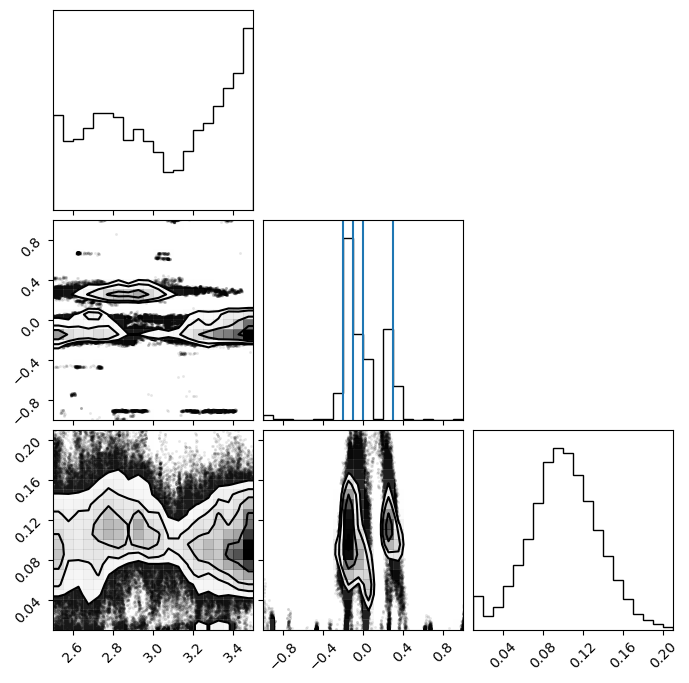

In [ ]:
samples = ensemble.get_chain()['gauss'][:, 0].reshape(-1, ndim)

# same as ensemble.get_chain()['gauss'][ensemble.get_inds()['gauss']]
samples = samples[~np.isnan(samples[:, 0])]

param_names = ['$A$', '$\mu$', '$\sigma$']

c = ChainConsumer()
c.add_chain(samples, parameters=param_names, color='#6495ed')
c.configure(shade=True, shade_alpha=0.2, bar_shade=True, usetex=True)

for ii in range(len(gauss_inj_params)):
    c.add_marker(gauss_inj_params[ii], parameters=param_names, marker_style="x", marker_size=100, color='#DC143C')
    
c.plotter.plot(figsize=(8,8), legend=False);
mpl.rcParams['text.usetex']=True # Update this becasue chaincnsumer is annoyinh

In [ ]:
samples = ensemble.get_chain()['sine'][:, 0].reshape(-1, ndims[1])
samples = samples[~np.isnan(samples[:, 0])]

param_names = ['$A_s$', '$\omega$', '$\phi$']

c = ChainConsumer()
c.add_chain(samples, parameters=param_names, color='orange')
c.configure(shade=True, shade_alpha=0.2, bar_shade=True, usetex=True)

for ii in range(len(sine_inj_params)):
    c.add_marker(sine_inj_params[ii], parameters=param_names, marker_style="x", marker_size=100, color='k')
    
c.plotter.plot(figsize=(8,8), legend=False);
mpl.rcParams['text.usetex']=True # Update this becasue chaincnsumer is annoyinh

# Searching for Gaussian pulses in 2D 

In this simple example we generate a noisy figure, which contains signals in the shape of 2D Gaussian pulses. We will attempt to estimate the nubmer of signals, as well as the level of the synthetic noise. First, we generate the data.

In [ ]:
num     = 100 # the number of step for each dimension
lowlim  = -10 # Low limit on each axis
highlim = 10  # high limit on each axis
npulses = 10  # The # of injected pulses

dx = (highlim - lowlim)/num # Get the discritization 

x, y    = np.mgrid[lowlim:highlim:dx, lowlim:highlim:dx] # Generate the grid

Now we define the parameters of the injection signals

In [ ]:
Amp    = np.random.uniform(.5, 1.5, size=(npulses)) # Draw an amplitude
spread = .2  # Keep their spread as fixed for simplicity. 
sigma  = spread * np.diag(np.ones(2))

Do the actual injection

In [ ]:
edges = 2 # Utility parameter, in order to avoid having signals at the border of our data set
 
# Draw the coordinates parameters
inj_coordinates = np.random.uniform(lowlim+edges, highlim-edges, size=(npulses, 2))

# Gather all parameters here
gauss_inj_params = [ [AA, xy[0], xy[1]] for AA, xy in zip(Amp, inj_coordinates)]

print(' * Parameters injected: \n\n', np.matrix(gauss_inj_params))

We then can define the model and likelihood functions

In [ ]:
# First we compute some constant terms of the Gaussian models (reminder: we have assumed a fixed spread for each pulse)
sigma_det = np.linalg.det(sigma)
sigma_inv = np.linalg.inv(sigma)
norm      = np.sqrt((2*np.pi)**2 * sigma_det)

def gaussian_flat(x, y, a, b, c):
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; 
    pos[:, :, 1] = y
    mu = [b, c]
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, sigma_inv, pos-mu)
    return a * np.exp(- fac / 2) / norm

def gaussian(X, Y, a, b, c):
    x = X[:,0]
    y = Y[0,:]
    # breakpoint()
    A = np.exp(-((x[:, None] - b) ** 2) / (2 * sigma[0,0]))
    B = np.exp(-((y[:, None] - c) ** 2) / (2 * sigma[1,1])) 
    # breakpoint()
    C =  A*B[:,None,:] # (np.expand_dims(A,axis=0) * np.expand_dims(np.transpose(B),axis=2))
    
    return np.transpose( a * C / norm , axes=(1,0,2))

def log_prob_fn(x, groups, X, Y, data, inds=None, fill_inds=[], fill_values=None):

    x1, x2 = x
    group1, group2 = groups
    a = x1[:, 0]
    b = x1[:, 1]
    c = x1[:, 2]
    n = num * num

    gauss_out  = gaussian(X, Y, a, b, c)
    num_groups = int(group1.max() + 1)
    template   = np.zeros((num_groups, num, num))
    for i in range(num_groups):
        inds1 = np.where(group1 == i)
        given_signal = gauss_out[:,:,inds1].squeeze().sum(axis=-1)
        template[i] += given_signal

    sig = np.atleast_2d(x2)[:,0]
    llh = - 0.5 * ( np.sum(((template - data)) ** 2, axis=(1, 2)) )
    llh *= 1/sig**2
    llh += - n*np.log(sig) - .5 * n * np.log(2.*np.pi)
    return llh

We then generate the noise and add our injections.

In [ ]:
sigma_noise = [[0.2]] # The nosie variance

noise = sigma_noise[0][0] * np.random.randn( num, num ) # Draw the random points for the noise

# Generate the data-set
injection = np.zeros( (num, num) )
for params in gauss_inj_params:
    injection += gaussian_flat(x, y, *params)
data = injection + noise

params = np.array(gauss_inj_params)

Plot everything below

In [ ]:
from matplotlib import cm

plt.figure(figsize=(17,7))
plt.subplot(121)
cf = plt.contourf(x, y, injection, 10, cmap=cm.PuBu)
plt.scatter(params[:,1], params[:,2], marker='x', color='#DC143C')
plt.colorbar(cf)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.subplot(122)
cf = plt.contourf(x, y, data, 10, cmap=cm.PuBu)
plt.scatter(params[:,1], params[:,2], marker='x', color='#DC143C')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar(cf)
plt.show()

We then need to configure models and set-up our sample, in a very similar manner as we did for the simpler case before. Like in the previous case, we have two models that we need to sample for. One refers to the pulse signals, which we need to also estimate their total number in the data, and the other is the overal noise (no dynamical parameter space here).   

In [ ]:
ndims        = [3, 1]           # The dimensions of the two models we sample for here (# of parameter for each pulse, and # of parameters for the noise)
nleaves_max  = [2*npulses, 1]   # Maximum number of components for each model type (noise is 1, because we don't want to use RJ MCMC on it).
branch_names = ["pulse", "noise"] 

priors = {
    "pulse": {
        0: uniform_dist(0.5, 2.),
        1: uniform_dist(lowlim, highlim),
        2: uniform_dist(lowlim, highlim),
    },
    "noise": {
        0: uniform_dist(0.000001, 2.),
    }
}

Below we generate the coordinates for each walker, as done before. First we need to define the number of Temperatures and walkers we want to use.

In [ ]:
ntemps = 10
nwalkers = 30

In [ ]:
coords = {
    name: np.zeros((ntemps, nwalkers, nleaf, ndim))
    for nleaf, ndim, name in zip(nleaves_max, ndims, branch_names)
}

sig1 = 0.0000001
for nleaf, ndim, name in zip(nleaves_max, ndims, branch_names):
    for nn in range(nleaf):
        if name == "pulse":
            if nn >= len(gauss_inj_params):
                kk = np.random.randint(low=0, high=npulses)
            else: 
                kk = nn
            coords[name][:, :, kk] = np.random.multivariate_normal(gauss_inj_params[kk], np.diag(np.ones(3) * sig1), size=(ntemps, nwalkers))
        else:
            coords[name][:, :, nn] = np.random.multivariate_normal(sigma_noise[nn], np.diag(np.ones(1) * sig1), size=(ntemps, nwalkers))  


inds = {
     name: np.random.randint(low=0, high=1, size=(ntemps, nwalkers, nleaf), dtype=bool)
     for nleaf, name in zip(nleaves_max, branch_names)
}

inds['pulse'][:, :, :3] = True

for name, inds_temp in inds.items():
    inds_fix = np.where(np.sum(inds_temp, axis=-1) == 0)

    for ind1, ind2 in zip(inds_fix[0], inds_fix[1]):
        inds_temp[ind1, ind2, 0] = True

groups = {
    name: np.arange(coords[name].shape[0] * coords[name].shape[1]).reshape(
        coords[name].shape[:2]
    )[:, :, None]
    for name in coords
}

groups = {
    name: np.repeat(groups[name], coords[name].shape[2], axis=-1) for name in groups
}

coords_in = {name: coords[name][inds[name]] for name in coords}
groups_in = {name: groups[name][inds[name]] for name in groups}

# We compute the initial likelihood value at the injected coordinates:
log_prob = log_prob_fn(
    [coords_in["pulse"], coords_in["noise"]],
    [groups_in["pulse"], groups_in["noise"]],
    x,
    y,
    data,
    fill_inds=[],
    fill_values=None,
)

What remains is to sample the dynamical parameter space! One last thing: Define proposal and initial temperature ladder:

In [ ]:
factor = 0.0001
cov    = {"pulse": np.diag(np.ones(3)) * factor, 
          "noise": np.diag(np.ones(1)) * factor}
moves = GaussianMove(cov)
betas = np.linspace(1.0, 0.0, ntemps)

Begin sampling. This might take a while, so you can reduce the `burnin` and `nsteps` to get a quick result.

In [ ]:

ensemble = EnsembleSampler(
    nwalkers,
    ndims,  # assumes ndim_max
    log_prob_fn,
    priors,
    args=[x, y, data],
    tempering_kwargs=dict(betas=betas),
    nbranches=len(branch_names),
    branch_names=branch_names,
    nleaves_max=nleaves_max,
    provide_groups=True,
    update_iterations=1,
    plot_iterations=-1,
    vectorize=True,
    moves=moves,
    rj_moves=True,
)

nsteps = 500 # Number of samples per walker

state = State(coords, log_like=log_prob.reshape(ntemps, nwalkers), betas=betas, blobs=None, inds=inds)
ensemble.run_mcmc(state, nsteps, burn=100, progress=True, thin_by=1)


We then plot the results below

In [ ]:
def get_clean_chain(coords, ndim, temp=0):
    """Simple utility function to extract the squeezed chains for all the parameters
    """
    naninds    = np.logical_not(np.isnan(coords[:, temp, :, :, 0].flatten()))
    samples_in = np.zeros((coords[:, temp, :, :, 0].flatten()[naninds].shape[0], ndim))  # init the chains to plot
    # get the samples to plot
    for d in range(ndim):
        givenparam = coords[:, temp, :, :, d].flatten()
        samples_in[:, d] = givenparam[
            np.logical_not(np.isnan(givenparam))
        ]  # Discard the NaNs, each time they change the shape of the samples_in
    return samples_in

In [ ]:
pulse_parameters = ["$A$", r"$x$", r"$y$"]
noise_parameters = ["$\sigma_\mathrm{noise}$"]

samples_pulses = get_clean_chain(ensemble.backend.get_chain(thin=1)['pulse'], ndims[0])
samples_noise = get_clean_chain(ensemble.backend.get_chain(thin=1)['noise'], ndims[1])

In [ ]:
c = ChainConsumer()

c.add_chain(samples_pulses, parameters=pulse_parameters, name='Pulses', color='#6495ed')
c.configure(bar_shade=True, tick_font_size=8, label_font_size=12, max_ticks=8, usetex=True, serif=True)

for ii in range(npulses):
    c.add_marker([gauss_inj_params[ii][0], gauss_inj_params[ii][1], gauss_inj_params[ii][2]], \
    parameters=pulse_parameters, marker_style="x", \
    marker_size=100, color='#DC143C') 

fig = c.plotter.plot(figsize=(8,8), legend=False);

In [ ]:
c = ChainConsumer()

c.add_chain(samples_noise, parameters=noise_parameters, name='noise', color='orange')
c.configure(bar_shade=True, tick_font_size=8, label_font_size=12, max_ticks=8, usetex=True, serif=True)

fig = c.plotter.plot(figsize=(4,4), legend=False, truth=sigma_noise[0]);

In [ ]:
def get_clean_k_chains(backend, temp=0):
    """ Utility funtion to get the k-order chains
    """
    inds = backend.get_value("inds")  # Get the leaves out
    branches = {name: np.sum(inds[name], axis=-1, dtype=int) for name in inds}
    for (branch) in (branches):  # Get the total number of components/branches per temperature
        if branch == list(branches.keys())[0]:
            k_chain = branches[branch][:, temp].flatten()
        else:
            k_chain += branches[branch][:, temp].flatten()
    return k_chain

In [ ]:
gauss_k_chain_baseline = get_clean_k_chains(ensemble.backend)

bns = (np.arange(1, nleaves_max[0] + 2) - 0.5)  # Get maximum allowed number of leaves for the given branch

fig = plt.figure(figsize=(5, 5))
plt.hist(
        gauss_k_chain_baseline-1,
        bins=bns,
        color='#6495ed',
        alpha=0.9,
        lw=2,
        histtype='step',
        density=True,
        hatch='///'
        )

plt.axvline(x=int(npulses), linestyle='--', lw=2, color='#DC143C')

plt.xticks(fontsize=12)
plt.yticks([])
plt.xlim(1, 20)
plt.xlabel("$\#$ of peaks in the data")
plt.show()

## Moves

Moves are generally implemented with the same three-tier structure that originated in `emcee`.

### Metropolis-Hastings

### Red Blue

### Reversible Jump

### Group Moves

### Gibbs Sampling

## Utilities

Eryn provides many different

## Transform Container

Transform containers are primary used in likelihood functions to transform the arrays incoming from the sampler to the proper setup for likelihood computation. It can transform parameters based on transform functions and fill values into a final array for any value that is fixed during sampling. 

It can be passed to the likeihood function as an `arg` or `kwarg`.

In [ ]:
# can be done with lambda or regular function
# must have same number of inputs and outputs at same index in outer arrays
def transform1(x, y):
    return x * y, y / x

# this will do transform lambda x, y: (x**2, y**2) before transform1
parameter_transforms = {0: lambda x: np.log(x), (1, 2): lambda x, y: (x**2, y**2), (0, 2): transform1}

fill_dict = {
    "ndim_full": 6,  # full dimensionality after values are added
    "fill_inds": np.array([2, 3, 5]),  # indexes for fill values in final array
    "fill_values": np.array([0.0, 1.0, -1.0]),  # associated values for filling
}

tc = TransformContainer(parameter_transforms=parameter_transforms, fill_dict=fill_dict)

x = np.random.uniform(0.1, 4.0, size=(40, 3))

# can copy and transpose values if needed
out = tc.transform_base_parameters(x, copy=True, return_transpose=False)
print(out)

[[ 1.34430332e+00  8.18476660e+00  2.04085062e+00]
 [ 6.13084562e+00  3.05533801e+00  9.02491102e+00]
 [ 1.22919430e-01  4.09284339e+00  8.98848192e-02]
 [ 1.37682690e+01  4.43150106e+00  8.51564654e+00]
 [-2.35042400e+01  1.28537672e-01 -8.27705025e+00]
 [ 7.97484932e+00  6.73574678e+00  6.14823024e+00]
 [ 2.59320275e-01  9.64475288e-02  1.37513201e-01]
 [-8.17047397e-01  1.55045479e+00 -3.07445121e+00]
 [ 6.52416821e+00  6.02094524e-01  3.17120639e+01]
 [ 1.88145380e+00  2.19345426e+00  1.03413566e+00]
 [ 1.08549778e+00  2.73794101e+00  1.66880988e+00]
 [-3.11686841e+00  8.76259250e+00 -1.01315516e+01]
 [ 1.07468368e+01  3.33838821e-01  7.21161330e+00]
 [ 1.99354097e-01  7.88161252e+00  5.14486740e-01]
 [ 7.32068082e+00  8.52043784e-01  5.89509603e+00]
 [ 1.78499311e+01  1.01376123e+01  1.02075227e+01]
 [-1.42947592e-01  3.88745948e+00 -4.96527085e+01]
 [ 1.66122107e+01  1.12101611e+01  1.22284604e+01]
 [ 3.20548797e-01  3.81104680e-02  2.75093058e-01]
 [ 3.33334357e-02  5.60021016e+

If you have mutliple branches in your sampler, you can add more than one `Transform Container`. 

In [ ]:
def lnprob(x1, group1, x2, group2, transform_containers):
    x = [x1, x2]
    for i, (x_i, transform) in enumerate(zip([x1, x2], transform_containers)):
        temp = transform.transform_base_parameters(x_i, copy=True, return_transpose=False)
        x[i] = transform.fill_values(temp)
        
    print(x)
    
    ## do more in the likelihood here with transformed information
    
# setup transforms for x1
parameter_transforms1 = {0: lambda x: np.log(x)}

# setup transforms for x2 
parameter_transforms2 = {(1, 2): lambda x, y: (x**2, y**2)}

# fill dict for x1
fill_dict1 = {
    "ndim_full": 6,  # full dimensionality after values are added
    "fill_inds": np.array([2, 3, 5]),  # indexes for fill values in final array
    "fill_values": np.array([0.0, 1.0, -1.0]),  # associated values for filling
}

# fill dict for x2
fill_dict2 = {
    "ndim_full": 5,  # full dimensionality after values are added
    "fill_inds": np.array([1]),  # indexes for fill values in final array
    "fill_values": np.array([-1.0]),  # associated values for filling
}

tcs = [
    TransformContainer(parameter_transforms=parameter_transforms1, fill_dict=fill_dict1), 
    TransformContainer(parameter_transforms=parameter_transforms2, fill_dict=fill_dict2),
]

num = 40
x1 = np.random.uniform(0.1, 4.0, size=(num, 3))
x2 = np.random.uniform(0.1, 4.0, size=(num, 4))

group1 = np.arange(num)
group2 = np.arange(num)

# it can be added via args or kwargs in the ensemble sampler
lnprob(x1, group1, x2, group2, tcs)


[array([[-0.56819236,  2.05566347,  0.        ,  1.        ,  1.70157891,
        -1.        ],
       [ 0.98420683,  0.80471591,  0.        ,  1.        ,  0.86993299,
        -1.        ],
       [-1.7915778 ,  2.27296471,  0.        ,  1.        ,  0.4577592 ,
        -1.        ],
       [-1.91887059,  1.95427347,  0.        ,  1.        ,  2.04501765,
        -1.        ],
       [ 1.33792689,  0.17095355,  0.        ,  1.        ,  3.25206687,
        -1.        ],
       [ 1.34800321,  2.84822691,  0.        ,  1.        ,  3.77657866,
        -1.        ],
       [ 0.229263  ,  3.83419582,  0.        ,  1.        ,  3.17212956,
        -1.        ],
       [ 0.79691907,  0.31199857,  0.        ,  1.        ,  2.50395197,
        -1.        ],
       [ 0.51709738,  2.40245944,  0.        ,  1.        ,  3.23815906,
        -1.        ],
       [-0.75006537,  0.32946041,  0.        ,  1.        ,  3.08583184,
        -1.        ],
       [ 0.01247352,  1.50185175,  0.        ,  1

# Choosing the optimal B-Spline order

In this section we will attempt to fit a spectrum using a shape-agnostic model based on B-spline interpolation. The motivation of the problem is to determine the optimal number of free knots that are best describing the data, avoiding over-fitting situations. A very useful package is [this](https://github.com/karnesis/spectral) one, which is a simple package for performing spectral analysis. Has a lot of window functions, but more importantly, it contains the log-PSD function, which we will use in order to reduce the computational complexity of the problem. For more invormation about the `lpsd` method you can check [this](https://pure.mpg.de/rest/items/item_150688/component/file_150687/content) paper. 

First we set-up the type of measurement. The duration, cadence, also try to define the total number of steps for our sampler.

In [ ]:
Tobs  = 1e6                     # Duration of data 
dt    = 10                      # Delta-t [s]
fs    = 1/dt                    # Sampling frequency
Ndata = int(Tobs/dt)            # Number of data points
tvec  = np.arange(0, Tobs, dt)  # Get the time vector
df    = 1.0/Tobs                # Define Delta-f
burnin=1000
nsteps=2000

We then need to simulate some time-series. We could totally do this directly in frequency domain, but we will generate synthetic time series in order to use the `lpsd` function, which is useful for now. We start by defining our "true", or "theoretical" PSD of the data, which we will use to generate our data-set.

In [ ]:

if (Ndata % 2)==0:              # Get the number of requencies
    nfft = int((Ndata/2)+1)
else:
    nfft = int((Ndata+1)/2)

F     = df*nfft                 # make the positive frequency vector
fvec  = np.arange(0, F, df)

# Define a smooth model for the PSD of the noise
fstar=8e-3
n1=-5
n2=5
amp = 1
noisemodel = lambda f : 1e-3/f + 50*f + amp * (f**(n1 + n2) / (fstar**n1 * f**n2 + fstar**n2 * f**n1) )

# Get the PSD of the noise using hte model above
Sn = noisemodel(fvec)

# Remove first nan (assume also zero-mean)
Sn[0] = 0

/var/folders/yz/xf637mpx56g2dvdv9d8v1fnm0000gn/T/ipykernel_13472/1282363938.py:14: RuntimeWarning: divide by zero encountered in true_divide
  noisemodel = lambda f : 1e-3/f + 50*f + amp * (f**(n1 + n2) / (fstar**n1 * f**n2 + fstar**n2 * f**n1) )
/var/folders/yz/xf637mpx56g2dvdv9d8v1fnm0000gn/T/ipykernel_13472/1282363938.py:14: RuntimeWarning: divide by zero encountered in power
  noisemodel = lambda f : 1e-3/f + 50*f + amp * (f**(n1 + n2) / (fstar**n1 * f**n2 + fstar**n2 * f**n1) )


Import the spectral module for convenience. It contains tons of windows and some spectral utility functions.

In [ ]:
from spectral import genTimeSeriesFromPSD, lpsd, welchpsd

We generate the time-series by `ifft`-ing from the PSD model we provided. We then compute the PSD of the data using hte Welch method. 

In [ ]:
navs = 30

## Generate time-series here
print('\n # Generating noisy data with \n\t Tobs: {} \n\tNdata: {} \n\t  dt: {} \n\t  df: {}\n\t '.format(Tobs, Ndata, dt, df))
my_data = genTimeSeriesFromPSD(Sn,fs) # I divide by two because the function assumes the 2-sided spectrum

f20, S20 = welchpsd(my_data, fs, int(Ndata/navs), win='nuttall4c')
fr1, S1 = welchpsd(my_data, fs, Ndata, win='nuttall4c')



 # Generating noisy data with 
	 Tobs: 1000000.0 
	Ndata: 100000 
	  dt: 10 
	  df: 1e-06
	 


In order to save some computatational time, we use the `lpsd` method, which is basically a method to compute the PSD of time-series, using the optimal number of averages at each frequeny. The frequency grid is equally spaced in log, and pre-defined. For more information, you can tcheck [this](https://www.sciencedirect.com/science/article/abs/pii/S026322410500117X?via%3Dihub) paper.

In [ ]:
f0 = 1e-4
f1 = 5e-2

fl, Sl, Sle, _, Kavs = lpsd(my_data, fs, Kdes=100, Jdes=200, flims=[f0, f1], win='nuttall4b', winalpha=0., olap=0.0, order=0, errrype='std', DOPLOT=False, VERBOSE=False)
errs = [np.absolute(Sle[0]), np.absolute(Sle[1])]

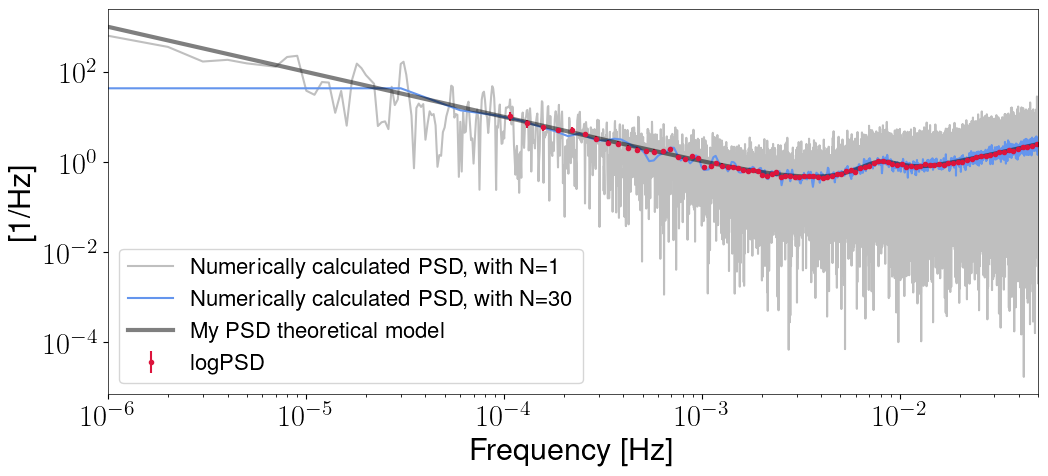

In [ ]:
plt.figure(figsize=(12,5))
plt.loglog(fr1, S1, label='Numerically calculated PSD, with N=1', color='grey', alpha=.5)
plt.loglog(f20, S20, label=f'Numerically calculated PSD, with N={navs}', color='cornflowerblue')
plt.errorbar(fl, np.absolute(Sl), yerr=errs, fmt='.', label='logPSD', color='crimson')

plt.loglog(fvec, Sn, alpha=0.5, color='k', linewidth=3, label='My PSD theoretical model')
plt.xlim(fvec[1], fvec[-1])
plt.ylabel('[1/Hz]')
plt.xlabel('Frequency [Hz]')
plt.legend(loc='lower left')

Now we setting up the sampler.

In [ ]:
maxmodels = 20
ntemps = 10
nwalkers = 10
backendname = 'a_test'

For this investigation, we need two models. One model concerns the knots at the edges of the spectrum, which we only do parameter estimation for their respective amplitude. So, no reversible jump for this one. We do this by simply setting the maximum number of leaves to `1`. The second model is the one that is dynamic, each component having an amplitude and a position parameter. We call those models `edges` and `knots` respectively.   

In [ ]:
ndims        = [2, 2] # The first is control point + knot, the second two control points (knots are the edges)
nleaves_max  = [maxmodels, 1]
nleaves_min  = [2, 1]
branch_names = ["knots", "edges"]

# Restrict the frequency band
i_band = np.where((fl>=f0) & (fl<=f1))[0]

mx = np.max(np.log(noisemodel(fl[i_band])))
mn = np.min(np.log(noisemodel(fl[i_band])))

print('max:', mx)
print('min:', mn)

#The prior on the knot amplitude could be dependent on the frequency, but I choose
#to be simple here
priors = {
    "knots": {
        0: uniform_dist(np.log(f0), np.log(f1)),
        1: uniform_dist(1.5*mn, 1.2*mx),
    },
    "edges": {
        0: uniform_dist(1.5*mn, 1.2*np.log(noisemodel(fl[0]))),
        1: uniform_dist(1.5*mn, 1.3*np.log(noisemodel(fl[-1]))),
    }
}

max: 2.2400506683151953
min: -0.7418475507541406


Setting up the input coordinates. This might be easier in the future, but hte functionality should remain.

In [ ]:

# Initialize the knots fr, 
coords = {
    name: np.zeros((ntemps, nwalkers, nleaf, ndim))
    for nleaf, ndim, name in zip(nleaves_max, ndims, branch_names)
}


sig1 = 0.0001
for nleaf, ndim, name in zip(nleaves_max, ndims, branch_names):
    print('# {}: Max models = {}, dim = {}'.format(name, nleaf, ndim))
    for nn in range(nleaf):
        if name == "knots":
            for dd in range(ndim):
                coords[name][:, :, nn, dd] = priors['knots'][dd].rvs(size=(ntemps,nwalkers))
        else:
            for dd in range(ndim):
                coords[name][:, :, nn, dd] = priors['edges'][dd].rvs(size=(ntemps,nwalkers)) # np.random.multivariate_normal(edges_starting_params[nn], np.diag(np.ones(2) * sig1), size=(ntemps, nwalkers))  

indxs = {
     name: np.random.randint(low=0, high=1, size=(ntemps, nwalkers, nleaf), dtype=bool)
     for nleaf, name in zip(nleaves_max, branch_names)
}

indxs['knots'][:, :, :3] = True

for name, inds_temp in indxs.items():
    inds_fix = np.where(np.sum(inds_temp, axis=-1) == 0)

    for ind1, ind2 in zip(inds_fix[0], inds_fix[1]):
        inds_temp[ind1, ind2, 0] = True

groups = {
    name: np.arange(coords[name].shape[0] * coords[name].shape[1]).reshape(
        coords[name].shape[:2]
    )[:, :, None]
    for name in coords
}

groups = {
    name: np.repeat(groups[name], coords[name].shape[2], axis=-1) for name in groups
}

coords_in = {name: coords[name][indxs[name]] for name in coords}
groups_in = {name: groups[name][indxs[name]] for name in groups}

# knots: Max models = 20, dim = 2
# edges: Max models = 1, dim = 2


Now we need to define the likelihood function. It hadles

In [ ]:
class SplineLikelihoodDynamic:

    def __init__(self, freq, log_per, N, inf=1e14, expmax = 500, kind='cubic', ftol=.1):
        """
        Gaussian likelihood model using a smoothed log-periodogram,
        assuming the data contains only noise.

        Parameters
        ----------
        fr : ndarray
            frequency array of the estimation domain, size nf
        log_per : ndarray
            log-periodogram array, size nf 
        N : ndarray
            array of averages per frequency, size nf 
        var : float
            variance of the log-periodogram bins
        instr : NoisePSD instance
            class to compute the instrumental log-PSD
        inf : float or np.inf
            if the likelihood diverge, it will be set equal to - inf
        expmax : float
            maximum value allowed in the exponential function. If this is reached,
            the log-likelihood will return -infinity.
        kind : string
            Interpolation kind. Set to 'cubic' by default.
        ftol : float [ 0 < ftol]
            Tolerance on proximity of knots in logspace
        """

        # Frequency of data
        self.freq   = freq
        self._Nsegs = N
        self._N     = len(freq)
        self.logfr  = np.log(freq)
        # Discrete Fourier transform of data (already normalized)
        self.log_per = log_per
        # Maximum value allowed in the exponential function
        self.expmax = expmax
        # Interpolation kind
        self.kind = kind
        # tolerance on proximity of knots in logspace
        self.ftol = ftol
        self.inf = inf

    def get_noise_psd_model(self, x, groups):
        """Get the spline model for the noise PSD, given some knots

        Parameters
        ----------
        x, groups : ndarray
            PSD parameters

        Returns
        -------
        instr : interpolate.interp1d evaluated
        """
        
        # I will consider two models. One handling the internal knots, and one for the edges
        x1, x2 = x
        group1, group2 = groups
        knots = x1[:, 0]
        control_points = x1[:, 1]

        # Get the edges info
        control_points_edges = x2

        num_groups = int(group1.max() + 1)
        # log_psd_model = np.zeros((num_groups, len(self.freq)))
        log_psd_model = np.empty((num_groups, len(self.freq)))
        log_psd_model[:] = np.nan
        failed = {}

        # Loop over the temperatures vs walkers
        for i in range(num_groups):
            inds1 = np.where(group1 == i)
            knots_i = knots[inds1]
            control_points_i = control_points[inds1]

            inds2 = np.where(group2 == i)
            control_points_edges_i = np.squeeze(control_points_edges[inds2])

            # Remove zeros 
            knots_i  = knots_i[knots_i != 0.]
            control_points_i = control_points_i[control_points_i != 0.]

            knots_list  = np.array([self.logfr[0]] + list(knots_i) + [self.logfr[-1]])
            control_pts = np.array([control_points_edges_i[0]] + list(control_points_i) + [control_points_edges_i[-1]])
            
            # Control for knots very close to each other
            if not np.any(np.diff(np.array(knots_list)) < self.ftol):
                # Change the data and reset the spline class
                interp_model = interpolate.interp1d(knots_list, control_pts, 
                	                                kind=self.kind, axis=-1, copy=True, 
                        	                        bounds_error=False,
                                	                fill_value="extrapolate",
                                        	        assume_sorted=False)
                log_psd_model[i] = interp_model(self.logfr)

                # To prevent overflow
                if np.any(log_psd_model[i] > self.expmax):
                    print('overflow!')
                    # breakpoint()
                    i_over = np.where((log_psd_model[i] > self.expmax) | (np.isnan(log_psd_model[i])))
                    log_psd_model[i][i_over] = np.nan
                    failed[i] = i_over
        # Return the correct quantity
        return np.exp(log_psd_model), failed

    def compute_psds(self, x, groups):
        """Compute PSD for all channels

        Parameters
        ----------
        theta : ndarray
            PSD parameters

        Returns
        -------
        s_tot : ndarray
            PSD estimate, size nf x nchannels
        """
        # Get the noise PSD models
        noise_psd_model, failed = self.get_noise_psd_model(x, groups)
        
        return noise_psd_model, failed 

    def evaluate(self, x, groups):
        """
        Calculate the log-likelihood.

        Parameters
        ----------
        c_est : ndarray
            vector of spline parameters.

        Returns
        -------
        ll : float
            log-likelihood value at x, computed from finds frequencies.
        """
        # Compute PSD model
        C, _ = self.compute_psds(x, groups)
        
        # Get the normalisation constants
        log2pi = - self._N * np.log(2.0*np.pi)
        
        # Log-likelihood calculation
        L = -1.* self.log_per / C
        
        # Sum the normalization factor here
        L = np.nan_to_num(.5 * self._Nsegs * ( L - np.log(C) + log2pi), nan= -np.inf)
        L = np.sum(L, axis=-1) 
        L[~np.isfinite(L)] = -self.inf
        
        return L

In [ ]:
# Instantiate and initalize likelihood again with different ftol
psdlike = SplineLikelihoodDynamic(fl[i_band].squeeze(), np.real(Sl[i_band]), Kavs[i_band], ftol=.05)

liekeval = psdlike.evaluate([coords_in["knots"], coords_in["edges"]], [groups_in["knots"], groups_in["edges"]])

print('llh shape = ', liekeval.shape)
print('liekeval = ', liekeval)

log_prob = liekeval.reshape(ntemps, nwalkers)

llh shape =  (100,)
liekeval =  [-1.00000000e+14 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14
 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14
 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14
 -4.38121585e+06 -1.00000000e+14 -1.00000000e+14 -4.31712393e+06
 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14
 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14
 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14
 -4.31768888e+06 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14
 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14 -4.31801556e+06
 -4.35693826e+06 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14
 -1.00000000e+14 -1.00000000e+14 -2.88589297e+08 -1.00000000e+14
 -4.29981691e+06 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14
 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14
 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14 -4.33027452e+06
 -1.00000000e+14 -4.32030703e+06 -1.00000000e+14 -1.000000

Now run the sampler!

In [ ]:
betas  = np.linspace(1.0, 0.0, ntemps)
factor = 0.0001
cov    = {"knots": np.diag(np.ones(2)) * factor, 
          "edges": np.diag(np.ones(2)) * factor}

moves = GaussianMove(cov)

backend = HDFBackend(backendname + ".h5")

ensemble = EnsembleSampler(
    nwalkers,
    ndims,  # assumes ndim_max
    psdlike.evaluate,
    priors,
    args=None,
    tempering_kwargs=dict(betas=betas),
    nbranches=len(branch_names),
    branch_names=branch_names,
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min,
    provide_groups=True,
    update_iterations=1,
    plot_iterations=-1,
    moves=moves,
    rj_moves=True,
    vectorize=True,
    backend=backend, 
)

print(' * Started sampling ...')
state = State(coords, log_like=log_prob, betas=betas, blobs=None, inds=indxs)

ensemble.run_mcmc(state, nsteps, burn=burnin, progress=True, thin_by=1)

print(' * Finished sampling!')

 * Started sampling ...


 17%|█▋        | 166/1000 [00:03<00:17, 48.60it/s]

overflow!


 64%|██████▍   | 643/1000 [00:12<00:07, 48.77it/s]

overflow!
overflow!
overflow!


 80%|███████▉  | 797/1000 [00:16<00:04, 50.29it/s]

overflow!


100%|██████████| 2000/2000 [01:01<00:00, 32.50it/s]

 * Finished sampling!


In [ ]:
baseline_run_backend = HDFBackend(backendname + ".h5") # Load the data from disk

In [ ]:
temp = 0 

ndim_knots = 2 # Set the dimensionality of each model
ndim_edges = 2

samples_knots = get_clean_chain(baseline_run_backend.get_chain()['knots'], ndim_knots)
samples_edges = get_clean_chain(baseline_run_backend.get_chain()['edges'], ndim_edges)

215132
40000


Plot the "squeezed" posterior surface for our parameters, for all `k` models.

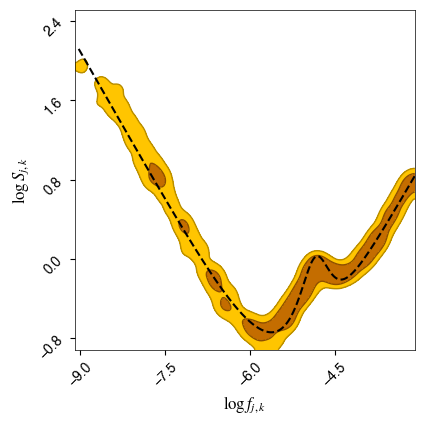

In [ ]:
paramnames = [r'$\log f_{j,k}$',r'$\log S_{j,k}$'] # Define parameter names

i_band = np.where((f20>=f0) & (f20<=f1))[0] # Keep only the range which we fitted in

c = ChainConsumer()
c.add_chain(samples_knots, parameters=paramnames, name='Knots in-between', color='orange')
c.configure(bar_shade=True, plot_hists=False)
fig = c.plotter.plot(figsize=(4, 4));
ff = np.linspace(np.log(f20[i_band][0]),np.log(f20[i_band][-1]), num=1000)
ax_list = fig.axes
ax_list[0].plot(ff, np.log(noisemodel(np.exp(ff))), color='k', lw=1.5,linestyle='--')
plt.show()

mpl.rcParams['text.usetex']=True # Update this becasue chaincnsumer is annoyinh

In [ ]:
def get_clean_k_chains(backend, temp=0):
    """ A simple function to get the chains of model order k

    Args:
        backend: The Eryn backend

    Returns:
        k_chain: the chains of the k order        
    """
    inds = backend.get_value("inds")  # Get the leaves out
    branches = {name: np.sum(inds[name], axis=-1, dtype=int) for name in inds}
    for (branch) in (branches):  # Get the total number of components/branches per temperature
        if branch == list(branches.keys())[0]:
            k_chain = branches[branch][:, temp].flatten()
        else:
            k_chain += branches[branch][:, temp].flatten()
    return k_chain

Text(0.5, 0, '$\\#$ of free knots')

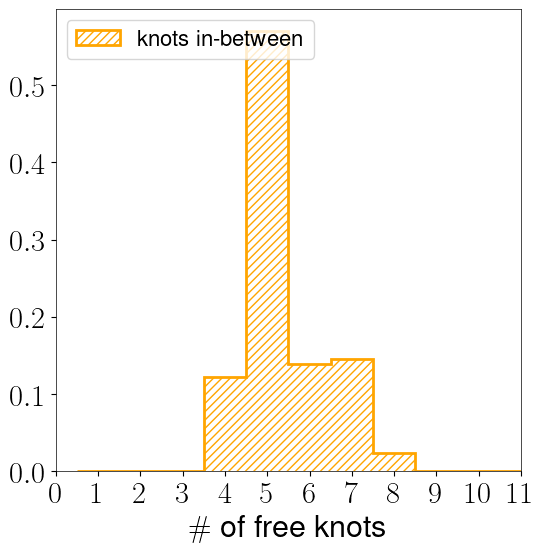

In [ ]:
knots_k_chain = get_clean_k_chains(baseline_run_backend)

bns = (np.arange(1, maxmodels + 2) - 0.5)  # Get maximum allowed number of leaves for the given branch 

mpl.rcParams['text.usetex']=True # Update this becasue chaincnsumer is annoying

fig = plt.figure(figsize=(6, 6))
probs, bins, rects = plt.hist(
        knots_k_chain-1,
        bins=bns,
        facecolor=None,
        histtype='step',
        edgecolor='orange',
        hatch='////',
        alpha=1,
        lw=2,
        density=True,
        label='knots in-between'
        )

plt.legend(loc='upper left')
plt.xticks(np.arange(0, maxmodels))
plt.xlim(0, 11)
plt.xlabel(r"$\#$ of free knots")

# $\sim fin \sim$